# Data and libraries

In [47]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import fsolve
import scipy.integrate as integrate
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [48]:
#Data

#Reactor
Pr=1500 #MW                             #Reactor power
iAs=180                                 #number of inner core assemblies
oAs=108                                 #number of outer core assembliess
p=10.7  #mm                             # pin pitch 
Npins=217                               #pins per assembly
Tcin=400 #°C                            #Inlet coolant temperature                        
Pincoolant=0.3 #Mpa                     #Inlet coolant temperature
mfr_ass=22 # (kg s-1)                   #Mass flow rate per assembly 
TargetB= 135 #GWd/t                     #Target Fuel burnup
fluxt=3.38*10**15 #cm^-1s^-1            #Total neutron flux
fluxf=0.7*fluxt #cm^-1s^-1              #Fast neutron flux


#Fuel pin
aL=1100 #mm                             #pin active length
lfeH=300 #mm                            #Lower fertile zone height
lfiH=250 #mm                            #Lower fissile zone height
ifeH=200 #mm                            #Inner fertile zone height
ufiH=350 #mm                            #Upper fissile zone height
fiRfi= 2.45/2 #mm                       #Fuel inner diameter (mm) – fissile pellets
feRfi=0                                 #Fuel inner diameter (mm) – fertile pellets
Rfo= 8.46/2 #mm                         #Fuel outer diameter
Rco=9.7/2 # (mm)                        #cladding outer radius
Wd=1 #mm                                #Wire spacer diameter
Pingas=0.1 #Mpa                           #Initial pin inner pressure
Tgas=20 #°C                             #Initial pin inner temperature
rhof=0.95 #%TD                          #Fuel density (percentage of theoretical density)
grainD= 10#micron                       #fuel grain diameter
Ppeak=46.3 # W/mm                       #axial peak power
x_fissile=0.03 #\                       #O-to-m ratio
alpha=1.2*10**-5 #°C**-1                #fuel expansion coefficient
v_f=0.32                                #Fuel Poisson Coefficient
#Axial peak factors
Pf=[0.001,0.005,0.01,0.03,0.205,0.38,0.45,0.51,0.55,0.57,0.58,0.315,0.05,0.04,0.04,0.05,0.06,0.08,0.46,0.84,0.89,0.94,0.98,1,0.98,0.92,0.86,0.81,0.77,0.71]
#Corrisponding height nodes
H=[0,130,230,290,300,310,350,400,450,490,540,550,560,590,630,670,700,740,750,760,770,790,830,880,930,980,1020,1050,1070,1100]

#constants
Nav=6.022*10**23 #atoms/mol             #Avogadro number
R=1.986  #cal/mol K                     #Gas constant    
E_av=2 #Mev                             #Average energy released per fission

#Molar Masses
MM_UO_2=238+16+16 #g/mol
MM_MOX= 16*(2-x_fissile)+(0.23*239+0.67*238)*(1+x_fissile)
                              

*Throttling-adjusted flow rate*

Throttling is the adjustement of the flow rate of a single assembly by opening and closing a valve at its inlet. By doing so, the heat exchenge can be enhanced or reduced.

For the scope of this work, it is sufficient to model this feature as a coefficient multiplying the standard mass flow rate.

In [49]:
throttling=1.9                         #throttling parameter
mfr=throttling*mfr_ass/(217)            #mass flow rate per pin adjusted by throttling

Pin-coolant Heat exchange geometrical parametrs

In [50]:
A=(p**2/4*math.sqrt(3)-math.pi*Rco**2/2)*10**-6 #m**2       #coolant channel section seen by a pin
Dh=4*A*1000/(math.pi*Rco) #m                                #Characteristic length of the pin (wet diameter)

# Interpolation

In this section, an interpolation of the axial peak factor is developed in order to calculate the temperature of the coolant along the pin active length.

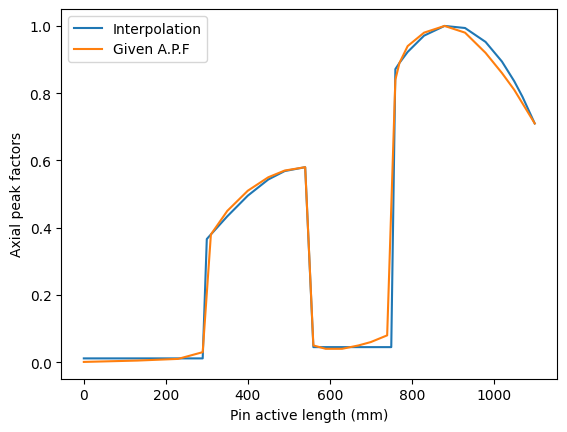

In [51]:
#values and parameters for the interpolations

#for f_1
val_f1=0                                       
for i in range(4):                             
    val_f1=val_f1+Pf[i]
########################

#for f_4 and f_3
val_f4=0                                      
for i in range(5):                            
    val_f4=val_f4+Pf[i+13]
###########################


#for f_3
m,q=sp.symbols('m q')                         
def f(x):                                      
    return m*x+q

x1=f(H[10])
x2=f(H[12])

sol_3=sp.solve( (sp.Eq(x1,Pf[10]), sp.Eq(x2,val_f4/6)), [m,q] )
###############################################################


#for f_5
C1,C2,C=sp.symbols('C1 C2 C')            
def f(x):
    return C+C1*x+C2*x**2
x1=f(H[20])
x2=f(H[23])
x3=f(H[29])
sol_5=sp.solve( (sp.Eq(x1,Pf[20]), sp.Eq(x2, Pf[23]), sp.Eq(x3,Pf[29])), [C1, C2, C])
####################################################################################

############################################################################################################################
###############   ACTUAL FUNCTIONS   ########################################################################################
#############################################################################################################################

def f1(x):                         #constant function interpolation of the axial peak factors (first fertile zone)
    return val_f1/4                #[0,300) 


#############################################################################################################################
def f2(x):                                     #sine function interpolation of the axial peak factors (first fissile zone)
                                               #[300,540)  
    return Pf[5]+(Pf[10]-Pf[5])*math.sin((x-H[5])*math.pi*0.5/(H[10]-H[5]))


#############################################################################################################################
def f3(x):                                   #linear interpolation of the axial peak factors (steep interface)
    return sol_3[m]*x +sol_3[q]                  #[540, 560)


#############################################################################################################################
def f4(x):                                    #constant function interpolation of the axial peak factors (second fertile zone)
    return val_f4/6                           #[560,700)


#############################################################################################################################


def f5(x):                                   #parabolic function interpolation of the axial peak factors (first fissile zone)
    return sol_5[C]+sol_5[C1]*x+sol_5[C2]*x**2     #[700,1100]


def PeakFactor(x):   #x is the disance from the bottom of the pin in mm, the function returns the value of the peak factor interpolated.
    if x<=H[3]:
        return(f1(x))
    elif x<=H[10]:
        return(f2(x))
    elif x<=H[12]:
        return f3(x)
    elif x<=H[18]:
        return(f4(x))
    else:
        return(f5(x))

Pfvals=[]
xvals=np.linspace(H[0],H[29],1101) #array of 1101, one for each active length mm
for i in range(len(H)):
    Pfvals.append(PeakFactor(H[i]))

plt.plot(H,Pfvals, label="Interpolation")
plt.plot(H,Pf, label="Given A.P.F")
plt.xlabel("Pin active length (mm)")
plt.ylabel("Axial peak factors")
plt.legend()

# Cold geometry

With cold geometry, we refer to the temperature profile, axial and radial, of the pin and the coolant without taking into account the deferormations due to temperature. The "cold" geometry is hence the geometry of the pin at 20°C.

Symbols used in the following:
* $\Gamma$:  Mass flow rate
* $C_p$:  coolant specific heat
* z: axial coordinate null at the basis of the pin active length
* $ q'(z)= A.P.F.(z) \cdot q'_{max} $ : linear power

**Coolant Temperature Profile**


The temperature profile of the coolant along the axial cordinates will evolve following the equation:
\begin{equation}
    \Gamma C_p\frac{dT}{dz}(z)=q'(z) \tag{1}
\end{equation}

This equation was integrated to find the coolant profile, knowing the inlet coolant temperature.





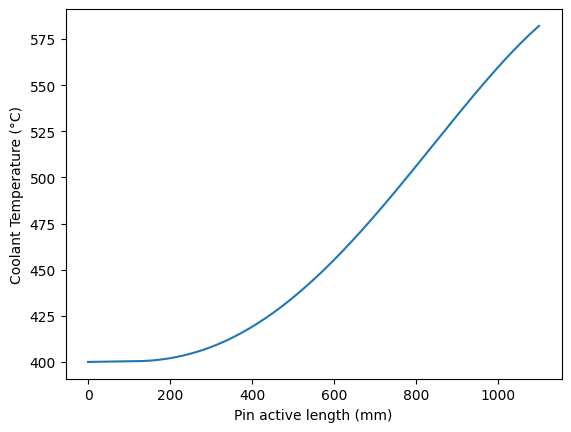

In [52]:
##Temperature conversion °C --> °F

#Celsius to Fahrenheit
def C2F(T):
  
  return (T*(9/5) + 32)

########################################################################
########################## COOLANT PROPERTIES ##########################
########################################################################

#Coolant heat capacity J/(K kg)
def Cp(T):
    return 971.34 - 3.69*10**(-1)*T + (3.43*10**(-4))*T**2


#Density (Kg m^-3)
def Rho(T):
  Tf=C2F(T)
  return 954.1579 + Tf * (Tf * (Tf * 0.9667*10**(-9) - 0.46*10**(-5)) - 0.1273534)

#coolant speed (m/s)
def v_c(T):
  return mfr/(Rho(T)*A*2)

#Thermal conductivity (W m^-1 K^-1)
def K_c(T):
  Tf=C2F(T)
  return 94 - 3.25*10**(-2)*Tf + 3.62*10**(-6)*Tf**2

#Peclet number
def Pe(T):
  return Rho(T)*v_c(T)*Dh*Cp(T)/K_c(T)

#Nusselt number
def Nu(T):
  return 7 + 0.025*(Pe(T))**(0.8)

#Heat transfer coefficient (W m^-2 K^-1)
def h(T):
  return Nu(T)*K_c(T)/(Dh)

########################################################################
########################## Coolant T profile ###########################
########################################################################

#Linear Power #W/mm
def Plin(z):

    return Ppeak*PeakFactor(z)  #the linear power @z is the max power Ppeak * the corresponding axial peak factor

# T coolant
def dTdz(z, T):  

    return (Plin(z)/(mfr*Cp(T)))

#solution of previous equation to find coolant temperature profile along z
sol=integrate.solve_ivp(dTdz, (H[0],H[29]), [400], t_eval=xvals[H[0]:H[29]+1]) 

plt.plot(sol.t, sol.y[0])
plt.xlabel("Pin active length (mm)")
plt.ylabel("Coolant Temperature (°C)")

T=np.zeros(len(H)) #coolant temperature @nodes
Cp_v=np.zeros(len(H)) #coolant specific heat @nodes

for i in range(len(H)):           #here, only the values of temperature and specific heat in proximity of the nodes are selected
    T[i]=sol.y[0][int(H[i])]
    Cp_v[i]=Cp(T[i])

By means of the provided correlations, the properties and characteristic parameters of interest for the coolant are calculated and plotted.

From now on, there is no more need for 1101 points in the calculations, but the analysis will be done in proximity of the nodes provided along with the axial peak factors.

The values of the needed parametrs like thermal conductivity, specific heat etc. will be calculated with the values relative to that points only.

These values will be used first to find the outer temperature of the cladding, and then inward with the inner cladding temperature until reaching the inner fuel temperature.

In [53]:
Rho_v=np.zeros(len(H)) #coolant density
v_c_v=np.zeros(len(H)) #coolant speed
k_c_v=np.zeros(len(H)) #cladding thermal conductivity
h_v=np.zeros(len(H))   #heat transfer coefficient
q=np.zeros(len(H))     #linear power
for i in range(len(H)): #here, only the values of coolant properties in proximity of the nodes are selected
    Rho_v[i]=Rho(T[i])
    v_c_v[i]=v_c(T[i])
    k_c_v[i]=K_c(T[i])
    h_v[i]=h(T[i])
    q[i]=Pf[i]*Ppeak   

There is a constraint on the speed of the coolant (<10 m/s) due to the fact that high-speed molten lead may corrode the cladding iron but if throttling rises, so does the speed while the cladding maximum temperatures lowers and vicde versa.


Hence, the need for choosing the throttling factor as a covenient trade-off between corrosion and pin temperature arises.

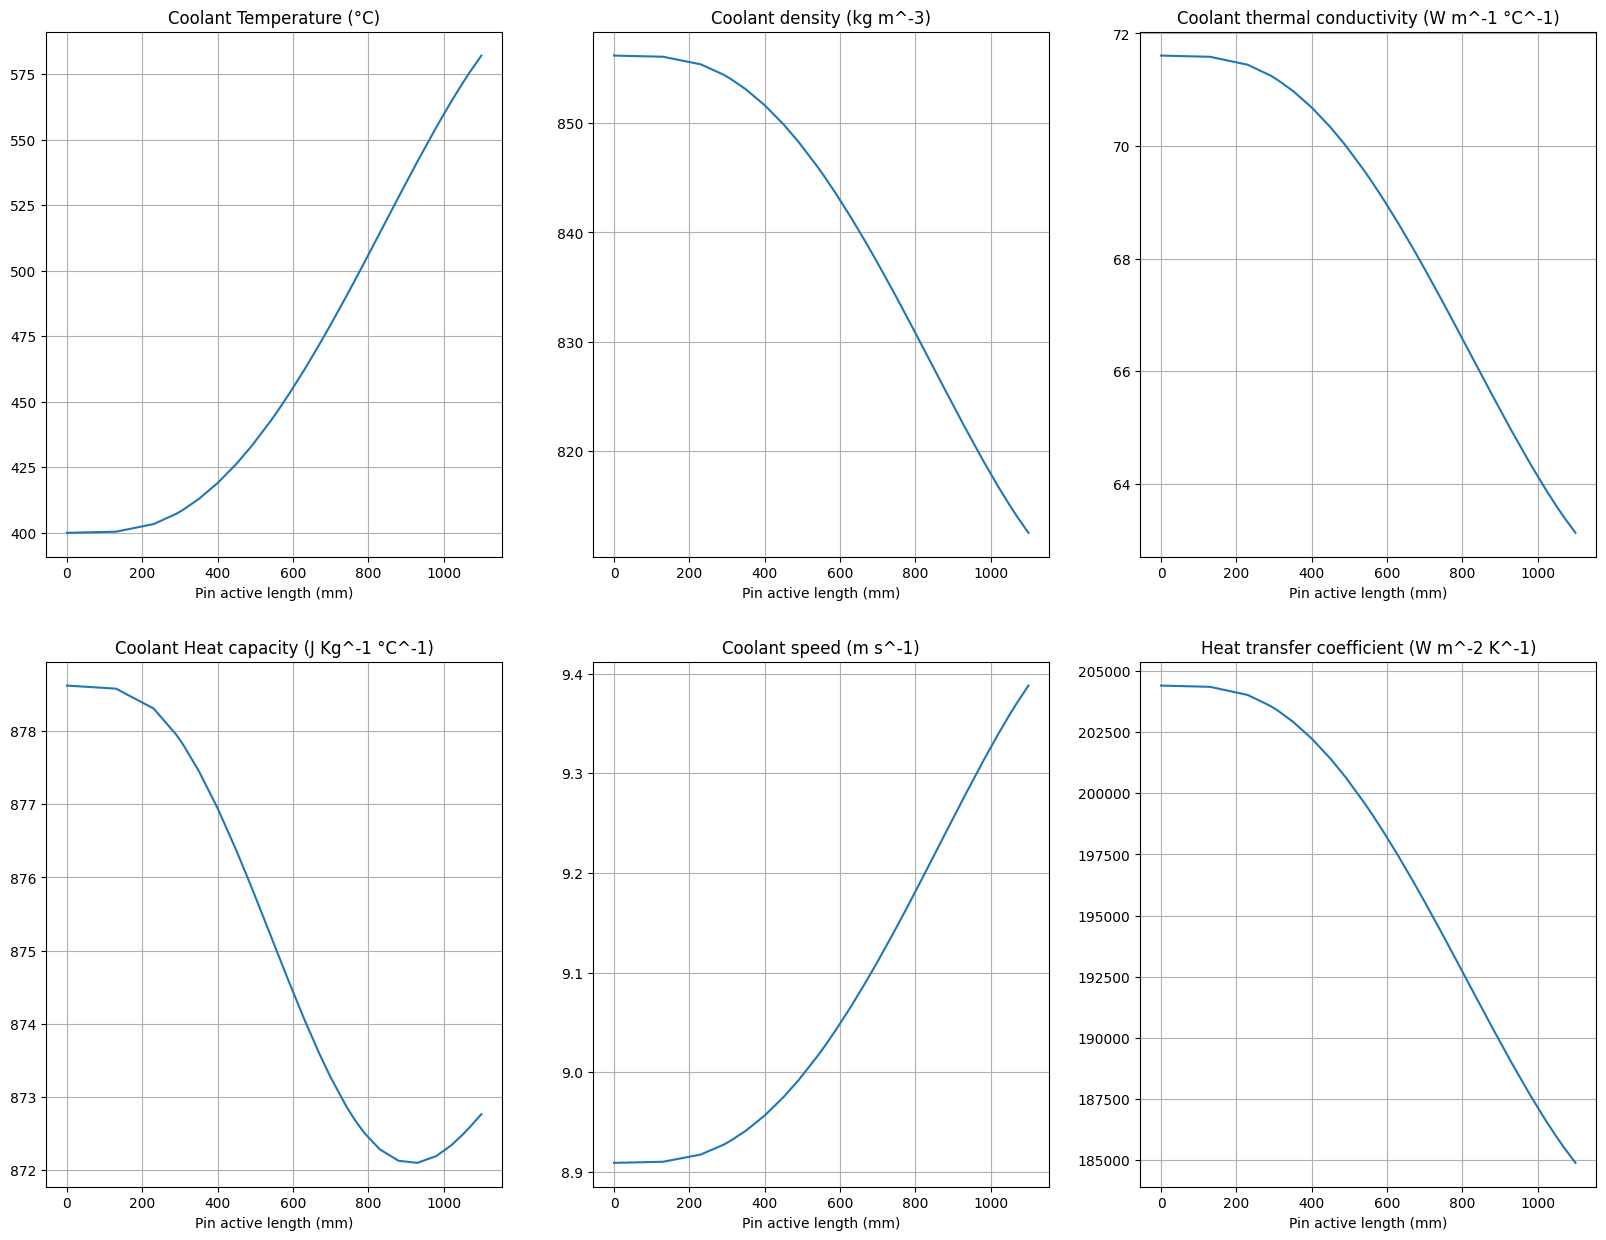

In [54]:
#plots                                                      #all coolant properties plotted
fig, axs = plt.subplots(2, 3, figsize=(20,15))

axs[0, 0].plot(H, T)
axs[0, 0].set_title('Coolant Temperature (°C)')
axs[0, 0].set_xlabel("Pin active length (mm)")
axs[0, 0].grid()
axs[1, 0].plot(H, Cp_v)
axs[1, 0].set_title('Coolant Heat capacity (J Kg^-1 °C^-1)')
axs[1, 0].set_xlabel("Pin active length (mm)")
axs[1, 0].grid()

axs[0, 1].plot(H, Rho_v)
axs[0, 1].set_title('Coolant density (kg m^-3)')
axs[0, 1].set_xlabel("Pin active length (mm)")
axs[0, 1].grid()
axs[1, 1].plot(H, v_c_v)
axs[1, 1].set_title('Coolant speed (m s^-1)')
axs[1, 1].set_xlabel("Pin active length (mm)")
axs[1, 1].grid()

axs[0, 2].plot(H, k_c_v)
axs[0, 2].set_title('Coolant thermal conductivity (W m^-1 °C^-1)')
axs[0, 2].set_xlabel("Pin active length (mm)")
axs[0, 2].grid()
axs[1, 2].plot(H, h_v)
axs[1, 2].set_title('Heat transfer coefficient (W m^-2 K^-1)')
axs[1, 2].set_xlabel("Pin active length (mm)")
axs[1, 2].grid()

**Cladding outern temperature profile**

The following assumptions are made in the calculations of $T_{c,o}(z)$:

$T_{c,o}(0)=400°C$: this is due to the heat transfer being assumed to be only radial and subsequently at $z=0$ there hasn't been any heat transfer yet. If at $z=0$ there is no heat transfer, then the cladding and coolant have same temperature.\
So:
\begin{equation}
T_{c,o,i}=T_{i}+\frac{q'_{max}P_{f,i}}{h(T_{i})2R_{c,o}π} \tag{2}
\end{equation}

Text(0.5, 0, 'Pin active length (mm)')

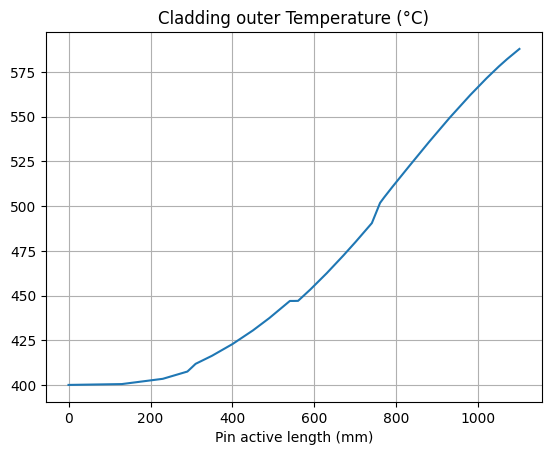

In [55]:
#Cladding outer temperature
Tco=np.zeros(len(H))

for i in range(len(H)):
  Tco[i]=T[i]+(q[i]*1000/(h_v[i]*2*math.pi*(Rco/1000))) #temperature calculated for each node

plt.plot(H,Tco)                               #temperature plotted vs pin active length
plt.grid()
plt.title('Cladding outer Temperature (°C)')
plt.xlabel("Pin active length (mm)")

**Cladding thickness problem**

The most basic geometrical limit for the cladding thickness is given by the fixed outern radius for both cladding and fuel.

In [56]:
#Cladding possible thickness
k=0
count=100
tc=np.zeros(count)

while k<count: #array of possible thickness values evluated for the cladding
    tc[k]=(Rco-Rfo)*k/count
    k=k+1

**Cladding inner temperature**\
For the calculation of the cladding inner temperature, we made the following assumptions:
1.  while calculating the thermal conductivity of the steel $K=K(T)$, we chosed as T the arithmetic average between inner and outer cladding temperature;
2.  we repeated the same assumption for $z=0$, by assuming $T_{ci}(z=0)=400°C$.

The inner cladding temperature was calculated as:

\begin{equation}
    T_{ci,i}=T_{co,i}+\frac{q'_{max}P_{f,i}}{K(\frac{T_{ci,i}+T_{co,i}}{2})2π}log(\frac{R_{c,o}}{R_{c,i}})  \tag{3}
\end{equation}


A cladding thickness is proposed (0.55 mm) and verified *a posteriori* given that the limit is T<620°C @ cladding midwall.

Since the maximum cladding temperature is 617.975076091893, which is lower than the midwall design limit, the result is deemed acceptable.


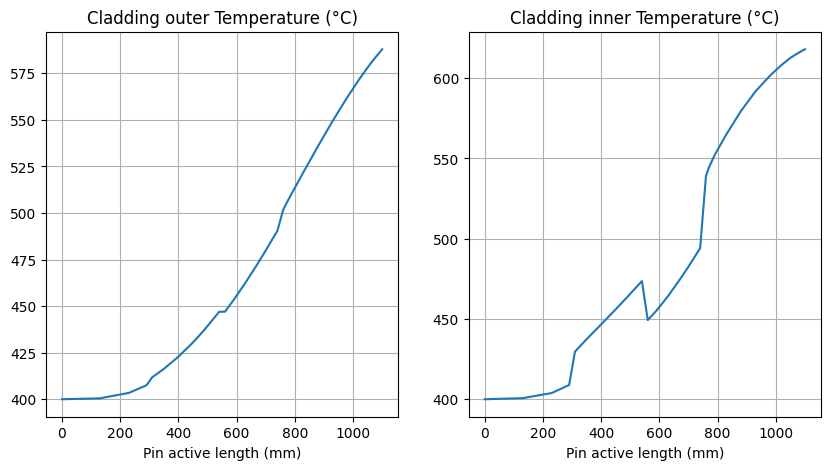

In [57]:
# Inner cladding temperature (equazione risolta con fsolve)
Tci=np.zeros(len(H))


#Thermal conductivity of the cladding #W/m/K
def k_cladding(T):
   
   return (13.95 + 0.01163*T) 

def Tcisolver(Tx, Tco_input, q_input, t_input): #this function implements eq. 3 where Tx is Tcii
        
        return ((Tx - Tco_input)/q_input) - (math.log(Rco/(Rco-t_input)))/(2*math.pi*k_cladding((Tx+Tco_input)/2)/1000)

#Cladding inner temperature

TC=0.55                     #proposed cladding thickness (mm)
Rci=Rco-TC                  #external radius of the cladding is the difference between external and thickness

Tci=np.zeros(len(H))

#for each node, the temperature is calculated as per eq. 3

for i in range(len(H)):
      sol=fsolve(func=Tcisolver, x0=400, args=(Tco[i], q[i], TC))
      Tci[i]=sol[0]


#plots
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(H, Tco)
axs[0].set_title('Cladding outer Temperature (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].grid()
axs[1].plot(H, Tci)
axs[1].set_title('Cladding inner Temperature (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].grid()

print("Since the maximum cladding temperature is " + str(max(Tci))+", which is lower than the midwall design limit, the result is deemed acceptable." )


**Fuel Outer temperature**\
In the evaluation of the temperature variation across the gap, the following assumptions are made:
1. only the term due to the conduction heat transfer is considered (at least for now). This is due to the fact that in cold geometry there is no contribution of contact pressure (there is no swelling/expansion) and the radiative contribution is order of magnitudes lower than the conduction term;
2. The $t_{eff}$ of the gap is calculated as:
\begin{equation}
    t_{eff}=R_{c,i}-R_{f,o}+t_{jump} \tag{4}
\end{equation}

\begin{equation}
    t_{jump}(He)≃10μm \tag{5}
\end{equation}
3.  We assumed $r_{gap}$ to be $r_{c,i}$ because it's the most conservtive estimate;
4.  Since $K=K(T)$, we used $T=\frac{T_{f,o}+T_{c,i}}{2}$ as a reference for K computation.

So:
\begin{equation}
T_{f,o}=T_{c,i}+q'(z)R_{gap}=T_{c,i}+\frac{q'(z)}{h(T)2πr_{gap}}=T_{c,i}+\frac{q'(z)t_{eff}}{K(\frac{T_{f,o}+T_{c,i}}{2})2πr_{gap}} \tag{6}
\end{equation}

Text(0.5, 0, 'Pin active length (mm)')

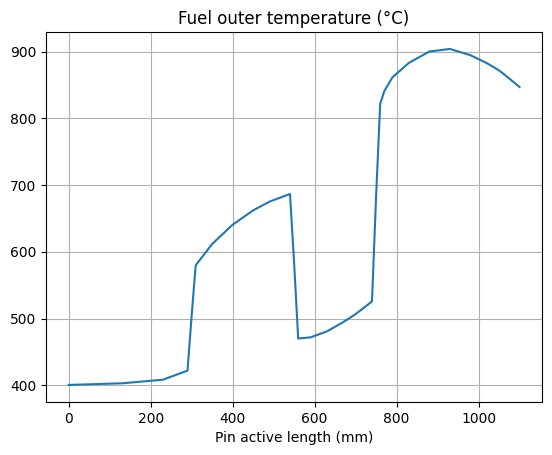

In [58]:
#Fuel outer temperature

i=0

Tfo=np.zeros(len(H))

def K_gap(T_input): #fuel-clkadding gap conductivity

    return 15.8*(10**(-4))*((273.15 + (T_input))**(0.79))

def Tfosolver(Tx, Tci_input, q_input, Rci_input, Rfo_input):

    return ((Tx - Tci_input)/q_input) - (Rci_input-Rfo_input)/(2*math.pi*Rci_input*(K_gap((Tx + Tci_input)/2))*0.001)

for i in range(len(H)):
    sol=fsolve(Tfosolver,1000, args=(Tci[i], q[i], Rci, Rfo))
    Tfo[i]=sol[0]


plt.plot(H,Tfo)
plt.grid()
plt.title('Fuel outer temperature (°C)')
plt.xlabel("Pin active length (mm)")

**Inner Fuel temperature**\
In the evaluation of the temperature variation across the fuel, the following assumptions and reasonings were made:
1.  for the porosity:
\begin{equation}
p=1-\frac{\rho_{real}}{\rho_{theoretical}} \tag{7}
\end{equation}
which is equivalent to stating that the deviation from the TD is due to the voids in the fuel material;
2.  for the burnup, $Bu=0$ because we are in cold geometry, we assume the fuel has just been inserted in the core;
3.  for the themal resistance, up to 300 mm and between 550 mm and 750 mm we deal with nat-u oxide pellets, otherwise it's MOX.

So:

\begin{equation}
T_{f,i}^{MOX}(z)=T_{f,o}+q'(z)R_{MOX} \tag{8}
\end{equation}

\begin{equation}
T_{f,i}^{UO_2}(z)=T_{f,o}+q'(z)R_{UO_2} \tag{9}
\end{equation}

And since the two kind of pellets have a different geometry:
\begin{equation}
R_{MOX}=\frac{1-log((\frac{r_{f,o}}{r_{f,i}})^2)}{(\frac{r_{f,o}}{r_{f,i}})^2-1}\frac{1}{4πK_{MOX}(\frac{T_{f,i}+T_{f,o}}{2},Bu, O/M)} \tag{10}
\end{equation}

\begin{equation}
R_{UO_2}=\frac{1}{4πK_{UO_2}(\frac{T_{f,i}+T_{f,o}}{2},Bu, O/M)} \tag{11}
\end{equation}

Text(0.5, 0, 'Pin active length (mm)')

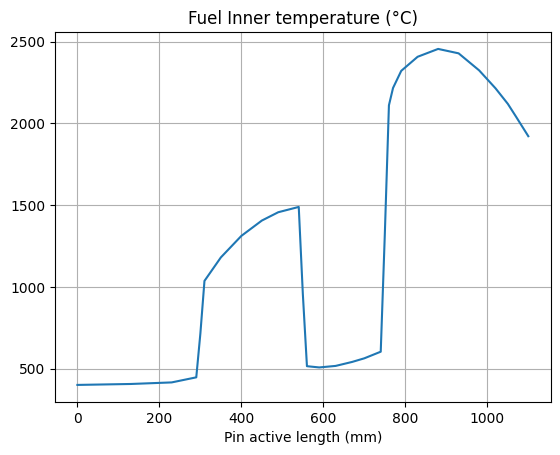

In [59]:
#Fuel inner temperature

Rfi=2.45/2 # mm

dev=0.05
BUFIMA=0 #cold geometry
por=0.05

Tfi=np.zeros(len(H))

def K_UO_2(burnup_input, T_input, p_input):  #fertile pellets, W/m K function of burnup, temperature and porosity of fuel

    return (1/(0.115+(2.6*10**(-3))*burnup_input+2.745*T_input*10**(-4))+1.216*10**(-2)*math.exp(1.867*T_input*10**(-3)))*((1-(2.58-5.8*T_input*10**-4)*p_input)/(1-((2.58-5.8*T_input*10**-4)*0.05)))

def Tfisolver_UO_2(Tx, Tfo_input, q_input, p_input):  #equation for inner T of fertile pellets

    return ((Tx - Tfo_input)/(q_input)) - 1/(4*math.pi*K_UO_2(0, (Tx+Tfo_input)*0.5, p_input)/1000)

def K_MOX(burnup_input, T_input, p_input, x_input): #fissile pellets, W/m K function of burnup, temperature, porosity of fuel and Pu content

    return (1/(1.528*math.sqrt(x_input+0.0093)-0.1055+0.44*burnup_input+2.885*T_input*10**-4)+76.4*(T_input**3)*10**(-12))*1.16*(1-p_input)/(1+2*p_input)

def Tfisolver_MOX(Tx, Tfo_input, q_input, Rfo_input, Rfi_input, p_input, x_input):#equation for inner T of fissile pellets
     
     return ((Tx - Tfo_input)/(q_input)) - (1-(math.log((Rfo_input/Rfi_input)**2))/((Rfo_input/Rfi_input)**2 -1))*(1/(4*math.pi*(0.001*K_MOX(0, 0.5*(Tx+Tfo_input), p_input, x_input ))))


for i in range(len(H)):
    if H[i]<=300 or (H[i]>=550 and H[i]<=750):
        sol=fsolve(Tfisolver_UO_2,1000, args=(Tfo[i], q[i], 1-rhof))
        Tfi[i]=sol[0]
    else:
        sol=fsolve(Tfisolver_MOX,1000, args=(Tfo[i], q[i], Rfo, Rfi, 1-rhof, x_fissile))
        Tfi[i]=sol[0]



plt.plot(H, Tfi)
plt.grid()
plt.title('Fuel Inner temperature (°C)')
plt.xlabel("Pin active length (mm)")

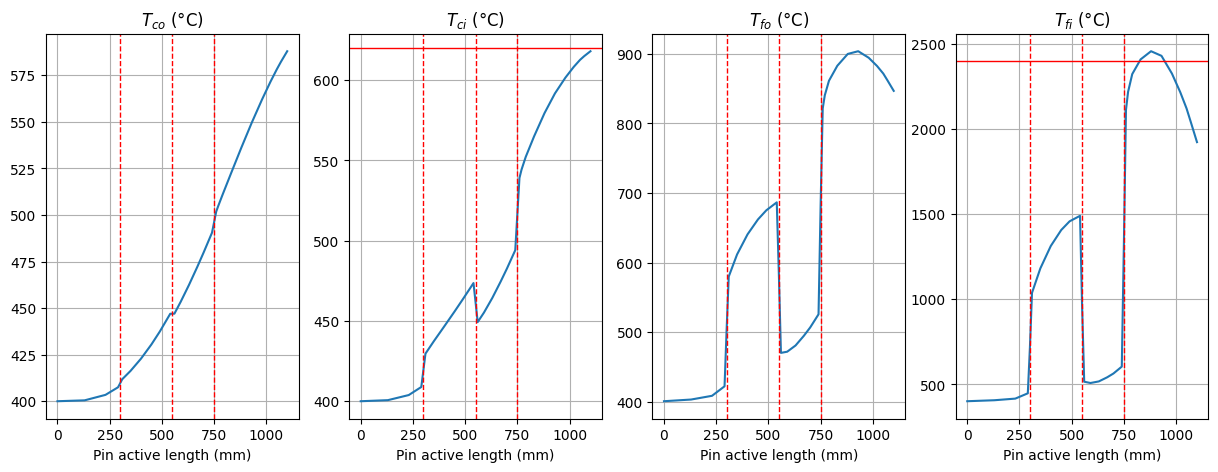

In [60]:
#plots of inner and outer temperatures for both cladding and fuel
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[0].grid()
axs[1].plot(H, Tci)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[1].axhline(y=620, color= "r", linestyle="-", linewidth=1)
axs[1].grid()
axs[2].plot(H, Tfo)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].set_xlabel("Pin active length (mm)")
axs[2].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[2].grid()
axs[3].plot(H, Tfi)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].set_xlabel("Pin active length (mm)")
axs[3].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[3].axhline(y=2400, color= "r", linestyle="-", linewidth=1)
axs[3].grid()

Note that the maximum inner fuel temperature exceeds the design limit for the fuel temperature (<2400°C) and that the dotted red lines demarcate the separation between fertile and fissile zones.

Yet, the cold geometry analysis does not take into account the thermal expansion of the materials involve, as seen later on in the hot geometry analysis. As shown, the thermal expansion of both fuel and cladding reduces the thermal resistance of the system and hence the maximum T.

Cold geometry temperature radial profile @ hottest node

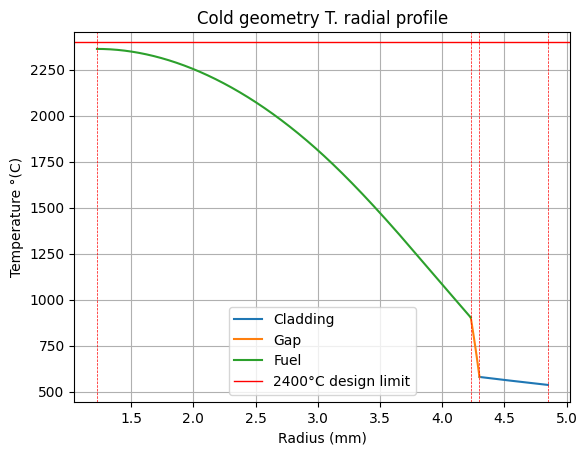

In [61]:
#ODEs to be integrated to evaluate the radial T profile

def dTdr_cladding (r,T,  q_input): #cladding

    return -q_input*1000/(2*math.pi*k_cladding(T)*r)

def dTdr_gap (r,T, q_input):#gas gap

    return -q_input*1000/(2*math.pi*K_gap(T)*r)

def dTdr_fuelMOX (r,T,q_input, Bu_input, p_input, x_input): #MOX fuel

    return -q_input*1000*(r**2-Rfi**2)/(Rfo**2-Rfi**2)/(2*math.pi*K_MOX(Bu_input, T, p_input, x_input)*r)

#arrays representinf cladding, gap and fuel radially
r_cladding=np.linspace(Rco,Rci, int((Rco-Rci)*1000))
r_gap=np.linspace(Rci,Rfo, int((Rci-Rfo)*1000))
r_fuel=np.linspace(Rfo,Rfi, int((Rfo-Rfi)*1000))

#ODEs integration
#the final T value of the cladding serves as boundary condition for the integration of the gap
#same goes for gap and fuel
cladding_cold_profile=integrate.solve_ivp(dTdr_cladding, t_span=(Rco, Rci), t_eval=r_cladding, y0=[Tco[np.where(Tfi==max(Tfi))[0][0]]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
gap_cold_profile=integrate.solve_ivp(dTdr_gap, t_span=(Rci, Rfo), t_eval=r_gap, y0=[cladding_cold_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
fuel_cold_profile=integrate.solve_ivp(dTdr_fuelMOX, t_span=(Rfo, Rfi), t_eval=r_fuel, y0=[gap_cold_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 1-rhof, x_fissile))

plt.plot(cladding_cold_profile.t, cladding_cold_profile.y[0], label="Cladding")
plt.plot(gap_cold_profile.t, gap_cold_profile.y[0], label="Gap")
plt.plot(fuel_cold_profile.t, fuel_cold_profile.y[0], label="Fuel")
plt.axvline(x=r_cladding[0], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_cladding[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_gap[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_fuel[-1], color="r", ls="--", linewidth=0.5)
plt.axhline(y=2400, color="r", linestyle="-", linewidth=1, label="2400°C design limit")
plt.ylabel("Temperature °(C)")
plt.xlabel("Radius (mm)")
plt.title("Cold geometry T. radial profile")
plt.legend()
plt.grid()


As shown, even though the previous estimate (axial) indicated that the maximum T was over the design limit, it is important to stress the fact that the axial approach require to estimate the properties of materials as uniform and to be calculated as a function of the average T of said material. This apprpximation leads to a slight overestimatation of the maximum inner temperature at the hottest point. Still, the temperature is dangerously close to said boundary.

# Hot geometry

The aim of this section is to use the temperatures found in the previous section to compute the thermal expansion of the materials.\
Under these new circumstances, we repeat the previously done calculation.

In [62]:
def epsilon(T_input): # T °C, epsilon \
    
    return -3.101*10**-4+1.545*10**-5*(T_input)+2.75*10**-9*(T_input)**2

The following equation will be applied for both internal and external radii, and for both cladding and fuel:
\begin{equation}
r=r_0[1+ϵ_{th}(T)]=r_0[1+α(T)(T-T_{ref})] \tag{12}
\end{equation}
The temperature for the cladding, the filling gas and the fuel will be the average between internal and external.

In [63]:
j=0 #counter fir the while loop

#geometry
Rco_hot=np.zeros(len(H))
Rci_hot=np.zeros(len(H))
Rfo_hot=np.zeros(len(H))
Rfi_hot=np.zeros(len(H))

#temperatures
Tco_hot=np.copy(Tco)
Tci_hot=np.copy(Tci)
Tfo_hot=np.copy(Tfo)
Tfi_hot=np.copy(Tfi)

while j<1000:
    
    #new geometry
    for i in range(len(H)):
        Rco_hot[i]=Rco*(1+epsilon((Tco_hot[i]+Tci_hot[i])/2))
        Rci_hot[i]=Rci*(1+epsilon((Tco_hot[i]+Tci_hot[i])/2))
        Rfo_hot[i]=Rfo*(1+alpha*(-25+(Tfo_hot[i]+Tfi_hot[i])/2))
        for i in range(len(H)):
            if H[i]<=300 or (H[i]>=550 and H[i]<=750):
                Rfi_hot[i]=0
            else:
                Rfi_hot[i]=Rfi*(1+alpha*(-25+(Tfo_hot[i]+Tfi_hot[i])/2))
        
        

    
    for i in range(len(H)):
        #Tco
        Tco_hot[i]=T[i]+(q[i]*1000/(h_v[i]*2*math.pi*(Rco_hot[i]/1000)))
        #Tci
        sol=fsolve(func=Tcisolver, x0=400, args=(Tco_hot[i], q[i], Rco_hot[i]-Rci_hot[i]))
        Tci_hot[i]=sol[0]
        #Tfo
        sol=fsolve(Tfosolver,1000, args=(Tci_hot[i], q[i], Rci_hot[i], Rfo_hot[i]))
        Tfo_hot[i]=sol[0]
        #Tfi
        if H[i]<=300 or (H[i]>=550 and H[i]<=750):
            sol=fsolve(Tfisolver_UO_2,1000, args=(Tfo_hot[i], q[i], 1-rhof))
            Tfi_hot[i]=sol[0]
        else:
            sol=fsolve(Tfisolver_MOX,1000, args=(Tfo_hot[i], q[i],Rfo_hot[i], Rfi_hot[i], 1-rhof, x_fissile))
            Tfi_hot[i]=sol[0]
    
    j=j+1

for i in range(len(H)): #check for contact between fuel and cladding due to th. expansion
    if Rfo_hot[i]>=Rci_hot[i]:
                print(j)
                print("Contatto fuel-cladding")


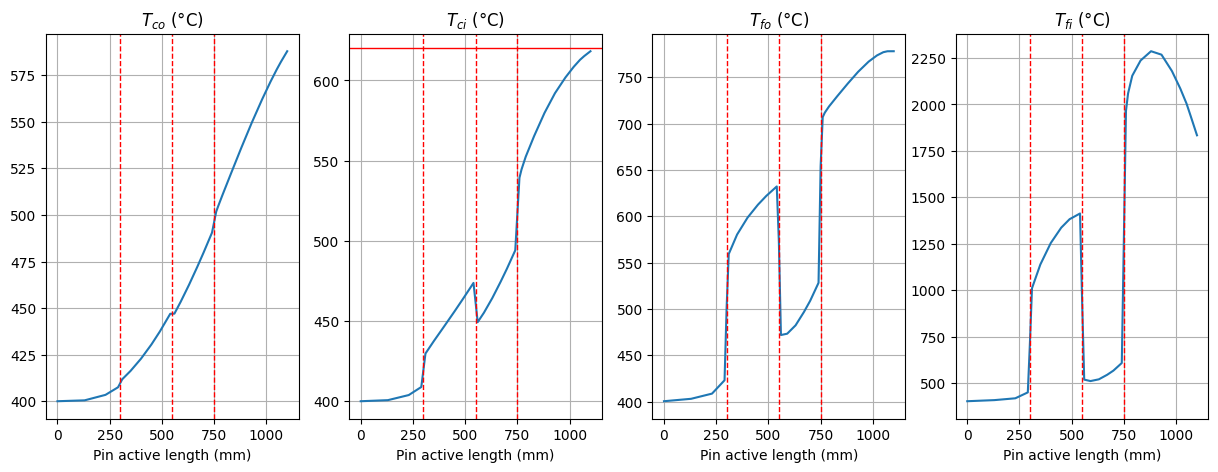

In [64]:
#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco_hot)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[0].grid()
axs[1].plot(H, Tci_hot)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[1].axhline(y=620, color= "r", linestyle="-", linewidth=1)
axs[1].grid()
axs[2].plot(H, Tfo_hot)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].set_xlabel("Pin active length (mm)")
axs[2].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[2].grid()
axs[3].plot(H, Tfi_hot)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].set_xlabel("Pin active length (mm)")
axs[3].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[3].grid()


This time, the T design limit for fuel (2400°C) is not reached even in the axial analysis. Note that at this point the swelling of fuel and claddding is not sufficient to allow for their contact.

Hot geometry temperature radial profile @ hottest node

In [65]:
r_cladding_hot=np.linspace(Rco_hot[np.where(Tfi==max(Tfi))][0],     Rci_hot[np.where(Tfi==max(Tfi))][0],      int((Rco_hot[np.where(Tfi==max(Tfi))]-Rci_hot[np.where(Tfi==max(Tfi))])*1000))
r_gap_hot=np.linspace(Rci_hot[np.where(Tfi_hot==max(Tfi_hot))][0],   Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],       int((Rci_hot[np.where(Tfi_hot==max(Tfi_hot))]-Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))])*1000))
r_fuel_hot=np.linspace(Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],     Rfi_hot[np.where(Tfi_hot==max(Tfi_hot))][0],         int((Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))]-Rfi_hot[np.where(Tfi_hot==max(Tfi_hot))])*1000))


cladding_hot_profile=integrate.solve_ivp(dTdr_cladding, t_span=(r_cladding_hot[0], r_cladding_hot[-1]), t_eval=r_cladding_hot, y0=[Tco[np.where(Tfi==max(Tfi))[0][0]]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
gap_hot_profile=integrate.solve_ivp(dTdr_gap, t_span=(r_gap_hot[0], r_gap_hot[-1]), t_eval=r_gap_hot, y0=[cladding_hot_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
fuel_hot_profile=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_fuel_hot[0], r_fuel_hot[-1]), t_eval=r_fuel_hot, y0=[gap_hot_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 1-rhof, x_fissile))



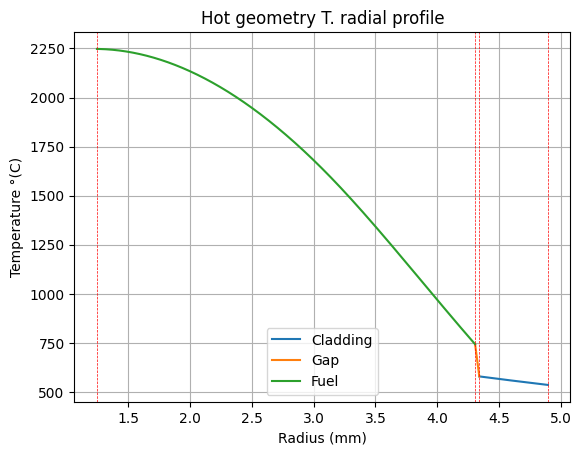

In [66]:
plt.plot(cladding_hot_profile.t, cladding_hot_profile.y[0], label="Cladding")
plt.plot(gap_hot_profile.t, gap_hot_profile.y[0], label="Gap")
plt.plot(fuel_hot_profile.t, fuel_hot_profile.y[0], label="Fuel")
plt.axvline(x=r_cladding_hot[0], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_cladding_hot[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_gap_hot[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_fuel_hot[-1], color="r", ls="--", linewidth=0.5)
plt.title("Hot geometry T. radial profile")
plt.xlabel("Radius (mm)")
plt.ylabel("Temperature °(C)",)
plt.grid()
plt.legend()

As for the cold geometry, the radial analysis of the hottest node shows that the approximate axial approach slightly overestimates the maximum temperature reached by the fuel. This time, the margin to the design limit is approximately 150°C.

# Fuel restructuring

The fuel material consists of uranium oxide for the fertile pellets and MOX for fissile pellets. In both cases, the material is porous. When the temperature increases aboce a certain threshold (1600°C), the porosities in the fuel tend to migrate following the temperature gradient. Since in the fuel the gradient points to the center, an anular region with no porosity forms, which stretches from the center of the fuel to the point where it reaches 1600°C and is called columnar region. 

The new internal radius, consequently, can be calculated by imposing the conservation of the mass enclosed by the columnar radius.

\begin{equation}
    \pi (R_{columnar}^2 - R_{f_i}^2) H \rho_{fuel} (1-porosity) = \pi (R_{columnar}^2 - R_{f_i, new}^2) H \rho_{fuel} \tag{13}
\end{equation}

By simplifying this equation, we obtain the following:

\begin{equation}
    R_{f_i,new} = \sqrt{R_{columnar}^2 - (1-porosity)(R_{columnar}^2-R_{f_i}^2)} \tag{14}
\end{equation}

This process is called fuel restructuring.

In [67]:
def R_columnar_solver(Rfi_input, Tx, Tfo_input, q_input, Rfo_input): #the root of this function is the columnar radius
     
     return ((Tx - Tfo_input)/(q_input)) - (1-(math.log((Rfo_input/Rfi_input)**2))/((Rfo_input/Rfi_input)**2 -1))*(1/(4*math.pi*(0.001*K_MOX(0, 0.5*(Tx+Tfo_input), 1-rhof, x_fissile ))))


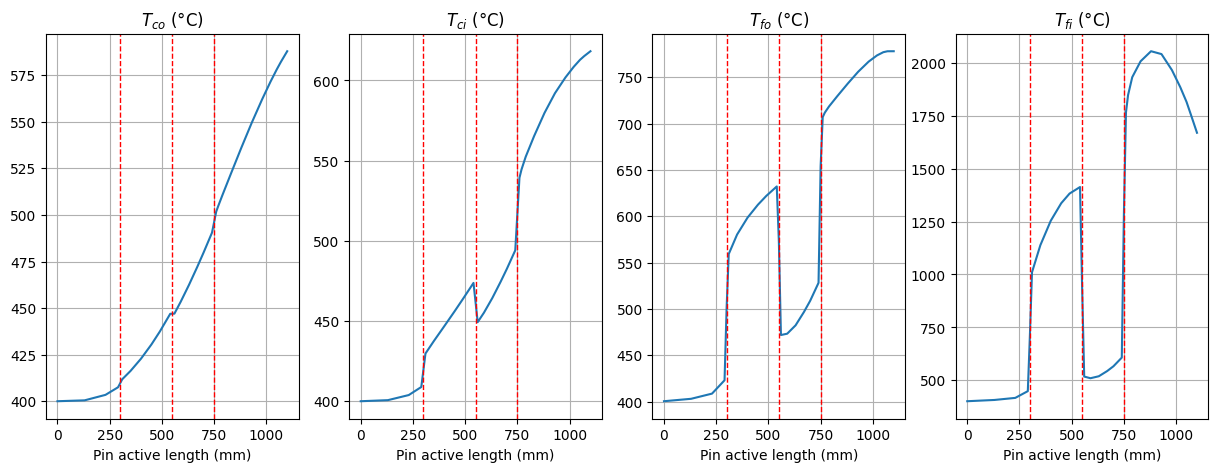

In [68]:
Rfi_res=np.zeros(len(H)) #new inner fuel radius
R_columnar=np.zeros(len(H)) #columnar radius
Tfi_res=np.zeros(len(H)) #new inner fuel temperature

for i in range(len(H)):
    if Tfi_hot[i]>=1600: #if the maximun temperature of the fuel reaches 1600°C, restructuring of the fuel takes place

        sol=fsolve(R_columnar_solver,Rfi, args=(1600,Tfo_hot[i], q[i], Rfo_hot[i])) #columnar radius calculatioon

        R_columnar[i]=sol[0]

        Rfi_res[i]=math.sqrt((R_columnar[i]**2)-rhof*(R_columnar[i]**2-Rfi_hot[i]**2))

        #new inner temperature is found after restructuring by modelling the columnar zone as a new inner cylindrical shell with a different porosity and hence a different thermal conductivity
        if H[i]<=300 or (H[i]>=550 and H[i]<=750): 
            sol=fsolve(Tfisolver_UO_2,1000, args=(Tfo_hot[i], q[i], 0))
            Tfi_res[i]=sol[0] 
        else:
            sol=fsolve(Tfisolver_MOX,1000, args=(Tfo_hot[i], q[i],Rfo_hot[i], Rfi_hot[i], 0, x_fissile))
            Tfi_res[i]=sol[0]

    else:
        Rfi_res[i]=Rfi_hot[i]
        Tfi_res[i]=Tfi_hot[i]


#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco_hot)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[0].grid()
axs[1].plot(H, Tci_hot)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[1].grid()
axs[2].plot(H, Tfo_hot)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].set_xlabel("Pin active length (mm)")
axs[2].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[2].grid()
axs[3].plot(H, Tfi_res)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].set_xlabel("Pin active length (mm)")
axs[3].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[3].grid()

As seen, the maximum temperature of the fuel is further lowered due to this phenomenon.

Moreover, when estimating the radial temperature profile, the fuel must be divided in two different regions, one of which is the columnar region.

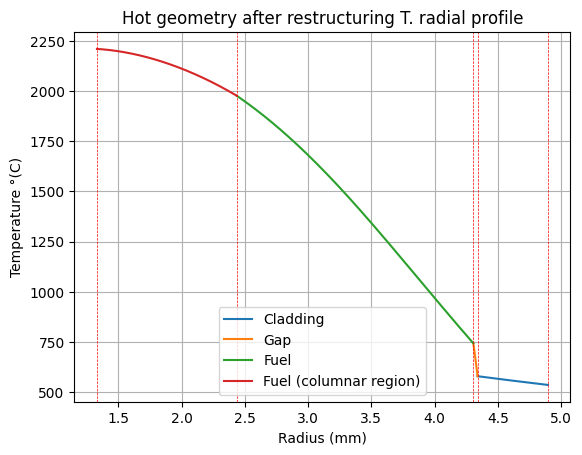

In [69]:
r_cladding_res=np.linspace(Rco_hot[np.where(Tfi==max(Tfi))][0],     Rci_hot[np.where(Tfi==max(Tfi))][0],      int((Rco_hot[np.where(Tfi==max(Tfi))]-Rci_hot[np.where(Tfi==max(Tfi))])*1000))
r_gap_res=np.linspace(Rci_hot[np.where(Tfi_hot==max(Tfi_hot))][0],   Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],       int((Rci_hot[np.where(Tfi_hot==max(Tfi_hot))]-Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))])*1000))
r_fuel_res=np.linspace(Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))][0],     R_columnar[np.where(Tfi_hot==max(Tfi_hot))][0],         int((Rfo_hot[np.where(Tfi_hot==max(Tfi_hot))]-R_columnar[np.where(Tfi_hot==max(Tfi_hot))])*1000))
r_columnar_res=np.linspace(R_columnar[np.where(Tfi_hot==max(Tfi_hot))][0],  Rfi_res[np.where(Tfi_hot==max(Tfi_hot))][0], int((R_columnar[np.where(Tfi_hot==max(Tfi_hot))]-Rfi_res[np.where(Tfi_hot==max(Tfi_hot))])*1000))


cladding_res_profile=integrate.solve_ivp(dTdr_cladding, t_span=(r_cladding_res[0], r_cladding_res[-1]), t_eval=r_cladding_res, y0=[Tco[np.where(Tfi==max(Tfi))[0][0]]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
gap_res_profile=integrate.solve_ivp(dTdr_gap, t_span=(r_gap_res[0], r_gap_res[-1]), t_eval=r_gap_res, y0=[cladding_res_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],))
fuel_res_profile_external=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_fuel_res[0], r_fuel_res[-1]), t_eval=r_fuel_res, y0=[gap_res_profile.y[0][-1]], args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 1-rhof, x_fissile))
fuel_res_profile_columnar=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_columnar_res[0], r_columnar_res[-1]), t_eval=r_columnar_res, y0=[fuel_res_profile_external.y[0][-1]],args=(q[np.where(Tfi==max(Tfi))[0][0]],0, 0, x_fissile))

plt.plot(cladding_res_profile.t, cladding_res_profile.y[0], label="Cladding")
plt.plot(gap_res_profile.t, gap_res_profile.y[0], label="Gap")
plt.plot(fuel_res_profile_external.t, fuel_res_profile_external.y[0], label="Fuel")
plt.plot(fuel_res_profile_columnar.t, fuel_res_profile_columnar.y[0], label="Fuel (columnar region)")
plt.axvline(x=r_cladding_res[0], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_cladding_res[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_gap_res[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_fuel_res[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_columnar_res[-1], color="r", ls="--", linewidth=0.5)
plt.ylabel("Temperature °(C)")
plt.xlabel("Radius (mm)")
plt.title("Hot geometry after restructuring T. radial profile")
plt.grid()
plt.legend()


This time, the axial analysis underestimates the temperature, which still is slightly lower than in the previous case (hot geometry) but not as much as the axial analysis would suggest. The difference amounts to almost 150°C.

# Fuel longitudinal expansion

The fuel expands longitudinally due to thermal swelling. This must be accounted for later on when establishing the length of the plenum that contains the fuel.

In [70]:
H_expanded=np.zeros(len(H))

H_expanded[0]=H[0] #new position of nodes

for i in range(len(H)-1): #each position is calculated as the undeformed 
    H_expanded[i+1]=H_expanded[i]+(H[i+1]-H[i])*(1+alpha*(-25+(Tfi_res[i+1]+Tfo_hot[i+1]+Tfi_res[i]+Tfo_hot[i])/2))



# Burnup, power and neutron flux analysis

The burnup of the fuel is calculated at every node such that the average value at the end of operation coincides with the target fuel burnup expressed in GWd/t. Then, it is converted to FIMA (Fissions per Initial Fissile Atom).

In [71]:
#Maximum Burnup along z calculation

def BurnupFinder(Burnup_max_value):
    x=0
    for i in range(len(H)):
        x=x+Pf[i]

    return x/len(H)*Burnup_max_value - TargetB

Burnup_max=fsolve(BurnupFinder, 100) #GWd/t



In [72]:
#Some useful function fo the conversion of burnup
#from GWd/t to fissions/heavy metal atom (FIMA)

def Joule_to_eV (Energy):

    return (Energy/1.602)*10**19

def GWd_t_to_J_g (Energy):

    return Energy*1000*24*60*60 

def eV_to_fissions (Energy):

    return Energy/200/10**6


In [73]:
burnup_final=np.zeros(len(H)) #burnup values at nodes (GWd/t)
burnup_final_FIMA=np.zeros(len(H))  #burnup values at nodes (FIMA)

for i in range(len(burnup_final)):
    burnup_final[i]=Burnup_max[0]*Pf[i] #GWd/t 

    temp= GWd_t_to_J_g(burnup_final[i]) #J/g
    temp=Joule_to_eV(temp) #eV/g
    temp=eV_to_fissions(temp) #fissions/g

    if H[i]<=300 or (H[i]>=550 and H[i]<=750): 
        
        burnup_final_FIMA[i]=temp*MM_UO_2/Nav
    else:
        burnup_final_FIMA[i]=temp*MM_MOX/Nav



Due to the burnup of the fuel, the power is expected to lower by 10% in four years, approximately linearly. As a consequence, the neutron flux will decrease and with it the yearly burnup contribution. In the following, the burnup is calculated at the end of each year, while the power and the neutron flux correspond to the value during the year.

In [74]:
def burnup_splitter(b_up_yearly, target): #this function is used to find the value of the contribution of each year
                                            #target is the final value of burnup
    return b_up_yearly*(1+0.975+0.95+0.925)-target

burnup_yearly=np.zeros([4,len(H)]) #Burnup array 4 years x 30 nodes
power_yearly=np.zeros([4,len(H)])  #Linear power array "
tot_neutron_flux_local=np.zeros([4,len(H)]) #total neutron flux array "

for i in range(len(burnup_yearly)):
    for j in range(len(burnup_yearly[i])):
        if i==0:
            burnup_yearly[i][j]=(fsolve(burnup_splitter, 0.1, args=(burnup_final_FIMA[j]))[0])
            tot_neutron_flux_local[i][j]=fluxt*Pf[j]
        else:
            burnup_yearly[i][j]=burnup_yearly[i-1][j]+burnup_yearly[0][j]*(1-0.025*j)
            tot_neutron_flux_local[i][j]=tot_neutron_flux_local[0][j]*(1-0.025*i)
        power_yearly[i][j]=q[j]*(1-0.025*i)
        

# Cladding void swelling

The previously calculated neutron flux can be used to estimate the void swelling of the cladding due to irradiation.

In [75]:
void_swelling=np.zeros([4,len(H)]) #dV/V (%) per each year at each node
void_swelling_total=np.zeros(len(H))#dV/V (%) cumulative at each node

#swelled outer cladding radii
Rco_new=np.zeros(len(H)) 
Rci_new=np.zeros(len(H))

def clad_void_swelling(T, phi,t): #dV/V (%)
    
    return 1.5*10**-3*math.exp(-2.5*((T-450)/100)**2)*(phi*t/10**22)**2.75

#the temperature used to calculate the swelling is the average between outer and inner T.
for i in range(len(void_swelling)):
    for j in range(len(void_swelling[i])):
        void_swelling[i][j]=clad_void_swelling((Tco_hot[i]+Tci_hot[i])/2, tot_neutron_flux_local[i][j], 360*24*60*60)



for j in range(len(H)):
    for i in range(len(void_swelling)):
        void_swelling_total[j]+=void_swelling[i][j] #the yearly contributions are summed

#the new radii are calculated
#approximatevely, the dilatation in a given direction (e.g. radial) can be estimated as the vol. dilatation/3
for i in range(len(H)):
    Rco_new[i]=Rco_hot[i]*(1+(void_swelling_total[i]/3/100))
    Rci_new[i]=Rci_hot[i]*(1+(void_swelling_total[i]/3/100))

# Fuel swelling

Under irradiation, not only the cladding undergoes void swelling but the fuel too. Just as previously done for the cladding, the new radii of the fuel, inner and outer, are estimated. Moreover, since it is of interest later on in the design of the length of the plenum containing the fuel, the axial swelling is estimated too.

In [76]:
#new inner and outer fuel radii
Rfi_new=np.zeros(len(H))
Rfo_new=np.zeros(len(H))

#new node position after swelling
H_swelled=np.zeros(len(H))

#since the node 0 represents the bottom of the fuel, which is the origin of the reference frame, its value is always 0
H_swelled[0]=H[0] #redundant, value already 0, but it is clearer

def swelling_strain(burnup): #(%), burnup in GWd/t

    return 0.07*burnup

for i in range(len(H)):
    #new radii
    Rfi_new[i]=Rfi_res[i]*(1+swelling_strain(burnup_final[i])*0.01/3)
    Rfo_new[i]=Rfo_hot[i]*(1+swelling_strain(burnup_final[i])*0.01/3)
    if i<len(H)-1: #axial swelling
        H_swelled[i+1]=H_swelled[i]+(H_expanded[i+1]-H_expanded[i])*(1+swelling_strain(burnup_final[i])*0.01/3)


# Fission Gas Release

For each fission event, two nuclei are produced. Among the nuclei most likely to be produced, Kr and Xe isotopes consist of a non negligible share of the total. These elements are noble gases that do not interact with the fuel and tend to migrate to the boundaries between fuel grains; almost 90% of them is then released in the cladding. These phenomenon is called fission gas release and contributes to the increase of the pressure inside the pin. Even more so, given the high temperature of the pin, the increase of the pressure will be substantial and must hence be accounted for in the design of the length of the plena. 

To account for this, the pin inside is divided in an upper plenum which contains the fuel and allows for its thermal expansion and void swelling. This region is very hot and is hence not optimal for storing fission gases.

Hence, a lower plenum below the fuel is left completely void to allow the flow of the fuel to a region with significantly lower T (400°C or whatever the inlet coolant pressure will be). 

This way, the FGR can be accomodated. One important constraint that must be respected other than the swelling of the fuel, is the total length of the pin, which is 2130 mm, to be divided between upper and lower plena.

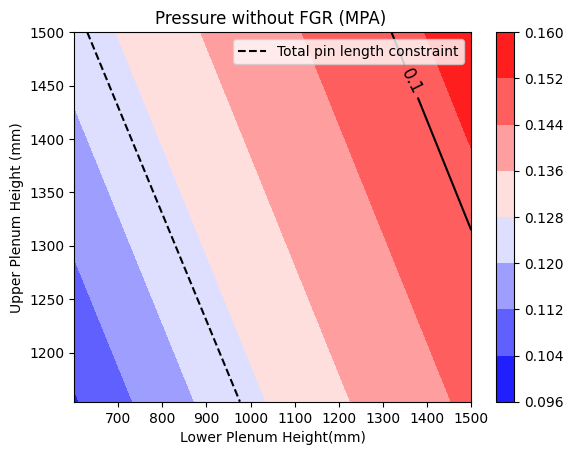

In [77]:
#These two arrays host the possible values for the length of the upper and lower plena of the fuel pin
#The lower boundary of the upper plenum length is set in order to be sufficently long to host the swelled
H_upper_plenum=np.linspace(int(H_swelled[-1])+1, 1500, 1500-int(H_swelled[-1]))
H_lower_plenum=np.linspace(601, 1500, 900)

#These two arrays will conatin the possible values of the volume of the empty space in the fuel pin at beginning and end of the  operative life
#given the lengths of the plena
Vin=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))
Vfin=np.zeros((len(H_upper_plenum),len(H_lower_plenum)))

#These arrays contain the value of the pressure at the end pf the operative life of the pin 
Pgas=np.zeros((len(H_upper_plenum),len(H_lower_plenum))) #without taking into account fission gas release
PgasFGR=np.zeros((len(H_upper_plenum),len(H_lower_plenum))) #and taking into account fission gas release

###################################################################
def V_upper(height, swelled): #this function takes in input the height of the upper plenum and the swelling state of the cladding
                                
    #the function returns the volume of the upper plenum 
    if swelled==False: 

        return math.pi*height*Rci**2
    
    else:
        Vol=0
        for i in range(len(H)-1):
            Vol=Vol+(H[i+1]-H[i])*math.pi*Rci_new[i+1]**2

        Vol=Vol+math.pi*(height-H_swelled[-1])*Rci_new[-1]**2

        return Vol
    
#####################################################################
def V_lower(height, swelled):#this function takes in input the height of the upper plenum and the swelling state of the cladding
    #the function returns the volume of the lower plenum 
    if swelled==False:
        return height*math.pi*Rci**2
    else:
        return height*math.pi*Rci_new[0]**2
    
#####################################################################
def V_initial(H_upper, H_lower): #this function returns the volume of the empty space inside the pin at the beginning of its operative life
                                 #given the length of the plena
    return V_upper(H_upper, swelled=False)+V_lower(H_lower, swelled=False)-math.pi*(Rfo**2-Rfi**2)*(1-por)*600-math.pi*(Rfo**2)*500*(1-por)

#####################################################################
def V_final(H_upper, H_lower):   #this function returns the volume of the empty space inside the pin at the end of its operative life
                                 #given the length of the plena
    Vfuel=0
    for i in range(len(H)-1):
        Vfuel=Vfuel+(H_swelled[i+1]-H_swelled[i])*math.pi*((Rfo_new[i]**-Rfi_new[i]**2)-por*(Rfo_new[i]**2-R_columnar[i]**2))

    return V_upper(H_upper, swelled=True)+V_lower(H_lower, swelled=True) -Vfuel*((1+swelling_strain(TargetB)/100))

#####################################################################
#the total volume of the free space is calculated at beginning and end of the operative life of the pin
#for each possible combination of plena lengths

for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        Vin[i][j]=V_initial(H_upper_plenum[i],H_lower_plenum[j])


for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        Vfin[i][j]=V_final(H_upper_plenum[i],H_lower_plenum[j])

# Plenum should be designed such that the final gas pressure is greater than the one of the coolant but below the 5MPa deisgn limit.
# The value of the pressure without accounting for FGR is calculated and displayed
for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        nHe=(Pingas*(10**6) * Vin[i][j]*10**(-9))/(8.3145*(Tgas+273))
        Pgas[i][j]=(nHe*8.3145*(400+273))/(Vfin[i][j]*10**(-9))*10**-6 # MPa

levels=[0.15, 0.30,0.45,0.6]
upper=[]
lower=[]
for i in range(len(H_lower_plenum)):
    for j in range(len(H_upper_plenum)):
        if H_lower_plenum[i]+H_upper_plenum[j]==2130:
            upper.append(H_upper_plenum[j])
            lower.append(H_lower_plenum[i])
            break



plt.figure()
plt.plot(lower, upper, color="k", linestyle="--", label="Total pin length constraint")
contour = plt.contour( H_lower_plenum,H_upper_plenum, Pgas, levels, colors = 'black')
contour_filled = plt.contourf(H_lower_plenum, H_upper_plenum,  Pgas, cmap='bwr');
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
plt.colorbar(contour_filled);
plt.title('Pressure without FGR (MPA) ');
plt.xlabel("Lower Plenum Height(mm)")
plt.ylabel("Upper Plenum Height (mm)")
plt.legend()

The heatmap shown above shows the pressure inside the cladding when heated entering the reactor without taking into account FGR. The black dashed line, instead, shows which combination of upper and lower plena lengths satisfy the total length constraint. Under these conditions, all those combinations are viable.

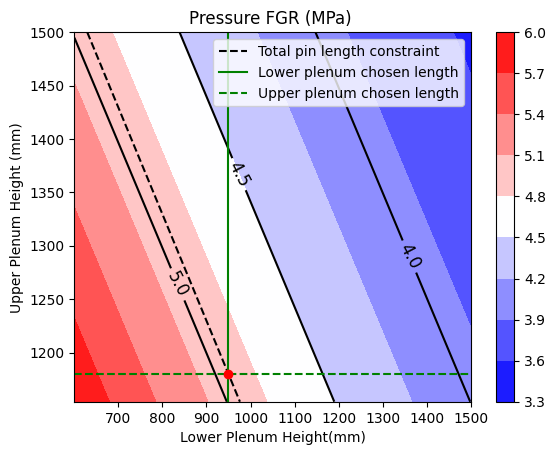

In [78]:
# Some data of interest only for the calculation of the effects of FGR

FGR=0.9 #amount of fission gas atoms rleased from fuel

YrateXe=0.27 # Xe atom released per fission event
YrateKr=0.03 # Kr atom released per fission event
EperFission=200 # Energy released per fission event (MeV)

DenUO2=11 # U oxide density (g/cm3)
DenPuO2= 11.5 # Pu oxide density (g/cm3)


Vfuelfiss=math.pi*(Rfo**2-fiRfi**2)*600 # volume of initial fissile material
Vfuelfert=math.pi*(Rfo**2)*500 # volume of initial fertile material

FuelMass=(Vfuelfiss*(10**(-3))*(DenUO2*0.77 + DenPuO2*0.23) + Vfuelfert*(10**(-3))*(DenUO2))*10**-3 # fuel mass (kg)

Etot=TargetB*(10**9 * 24*60*60)*(FuelMass*10**(-3)) # total energy generated in the whole life of the fuel pin (J)

aFissionEvents=Etot/(EperFission*(10**6) * 1.6*10**(-19)) # all fission events inside a fuel pin

nXe=YrateXe*aFissionEvents/Nav # atoms of Xe produced (mol)
nKr=YrateKr*aFissionEvents/Nav # atoms of Kr produced (mol)

n=nHe+FGR*(nXe+nKr) # fission gas atoms that are realesed in the plenum (mol)


# For each possible plena lengths combination, the final inner pressure of the cladding is calculated and displayed accounting for FGR
for i in range(len(H_upper_plenum)):
    for j in range(len(H_lower_plenum)):
        PgasFGR[i][j]=Pgas[i][j] +FGR*(nKr*8.3145*(400+273))/(Vfin[i][j]*10**(-3)) + FGR*(nXe*8.3145*(400+273))/(Vfin[i][j]*10**(-3))# MPa




levels = [4.0,4.5,5.0,6.0]
plt.figure()
plt.plot(lower, upper, color="k", linestyle="--", label="Total pin length constraint")
contour = plt.contour( H_lower_plenum,H_upper_plenum, PgasFGR, levels, colors = 'black')
contour_filled = plt.contourf(H_lower_plenum, H_upper_plenum,  PgasFGR, cmap='bwr');
plt.clabel(contour, colors = 'black', fmt = '%2.1f', fontsize=12);
plt.colorbar(contour_filled);
plt.title('Pressure FGR (MPa) ');
plt.xlabel("Lower Plenum Height(mm)")
plt.ylabel("Upper Plenum Height (mm)")
plt.axvline(x=H_lower_plenum[950-600-1], color='g', linestyle='-', label='Lower plenum chosen length')
plt.axhline(y=H_upper_plenum[1180-int(H_swelled[-1]+1)], color='g', linestyle='--', label='Upper plenum chosen length')
plt.plot(950, 1180, "ro")
plt.legend()


In this new heatmap, the FGR has been accounted for in the pressure calculation and the pressure significacntly increases. The range of combinations that satisfies the total length of the pin boundary are close to the 5.0 MPa design limit. The design choice is shown in the heatmap.

# Thermal analysis of fuel-cladding contact

Due to the void swelling of the fuel, eventually the gap between cladding and fuel might close. At each node the contact day between fuel and cladding is evaluated along with the relative radius.

In [79]:
contact_time=[] #array of day of fuel-cladding contact
Rci_contact=[]  #array of radius of fuel-cladding contact

for i in range(len(H)):

    def contact_day(t): #the root of this equation is the contact day

        return (Rci_hot[i]*(1+(void_swelling_total[i]*t/1440/3/100)))-Rfo_hot[i]*(1+swelling_strain(burnup_final[i]*t/1440)/100/3)
    
    day=fsolve(contact_day, 100)
    contact_time.append(int(day[0]))
    Rci_contact.append(Rci_hot[i]*(1+(void_swelling_total[i]*day[0]/1440/3/100))) #contact radius



At this point, the temperature profile of the cladding and the fuel is calcualted again taking into account the contact between cladding and gap in the nodes where it is reached. The power is reduced by 10% to take into account the decrese in linear power.

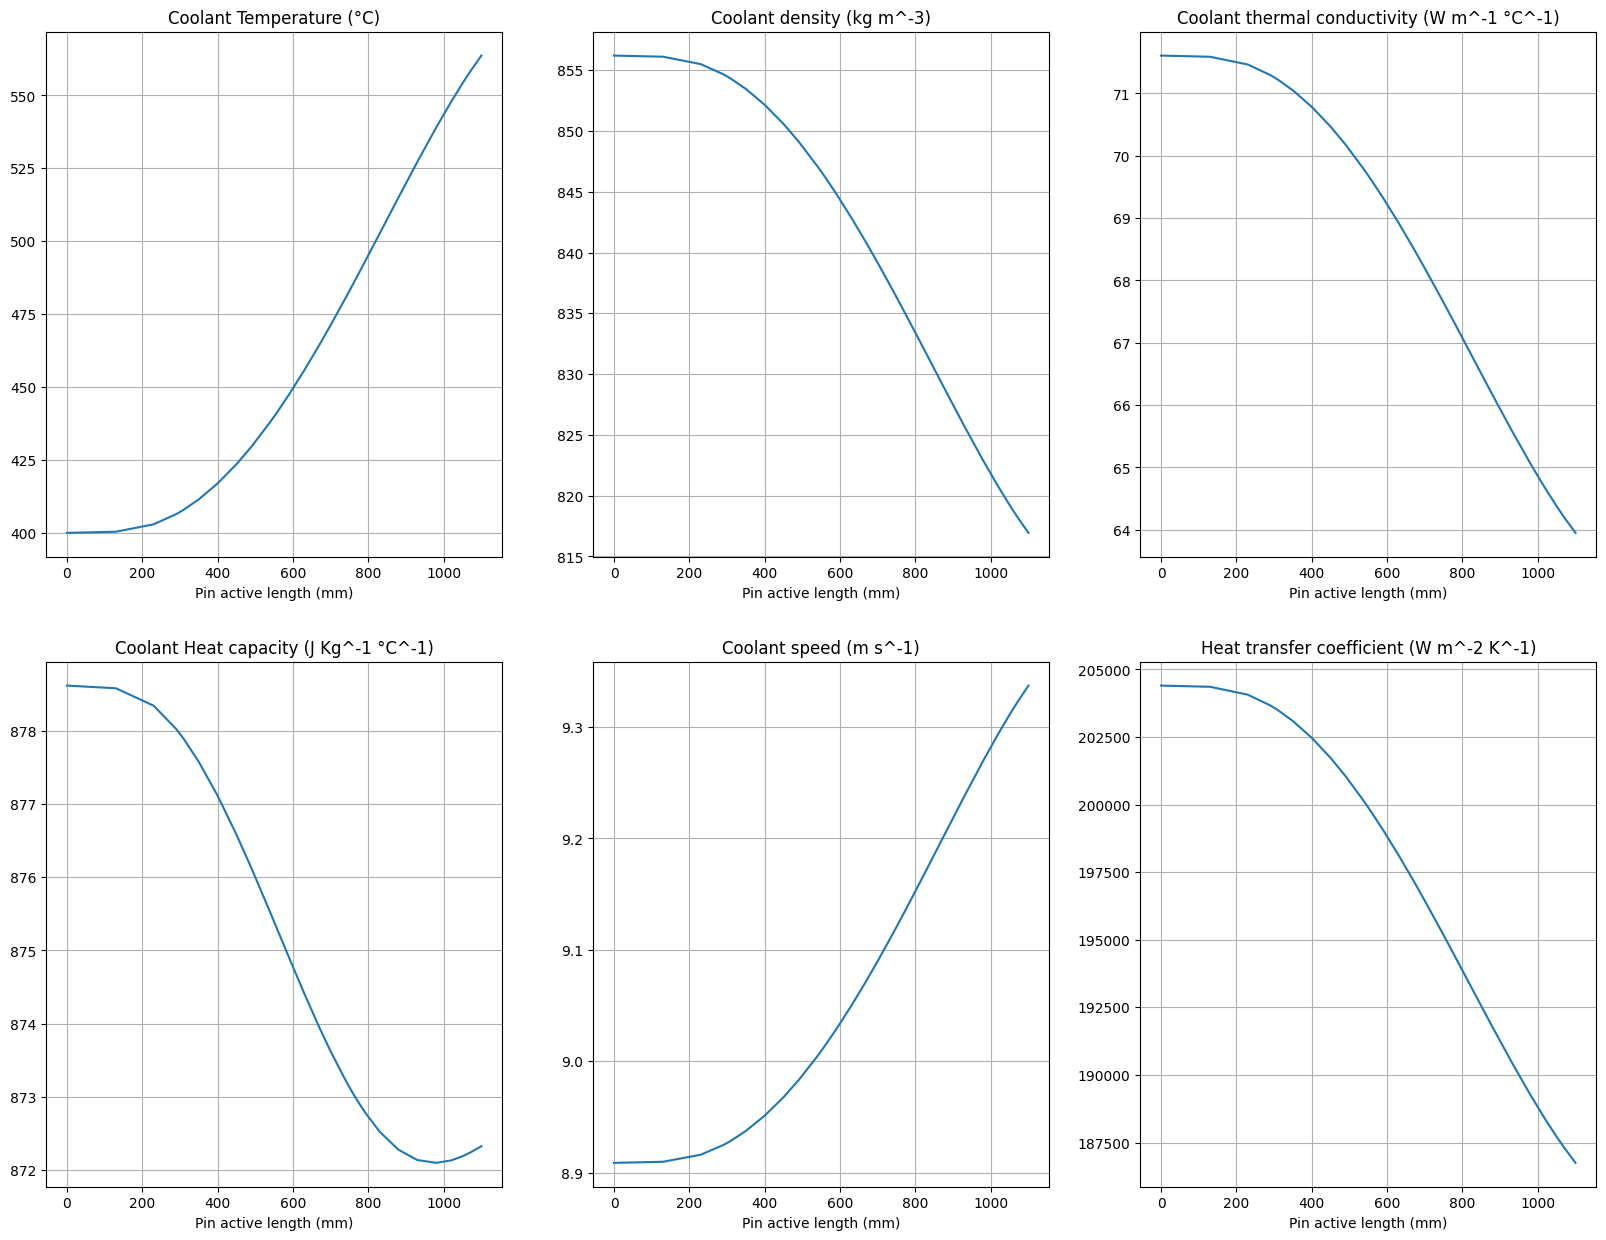

In [80]:
Tco_final=np.zeros(len(H))  #outer cladding temperature
Tci_final=np.zeros(len(H))  #inner cladding temperature
Tfo_final=np.zeros(len(H))  #outer fuel temperature
Tfi_final=np.zeros(len(H))  #inner fuel temperature
T_final=np.zeros(len(H))    #coolant temperature @nodes
Cp_v_final=np.zeros(len(H)) #coolant specific activity @nodes

#inner and outer radii of cladding and fuel
Rco_final=np.zeros(len(H)) 
Rci_final=np.zeros(len(H))
Rfo_final=np.zeros(len(H))
Rfi_final=np.zeros(len(H))

Rho_v_final=np.zeros(len(H)) #coolant density
v_c_v_final=np.zeros(len(H)) #coolant speed
k_c_v_final=np.zeros(len(H)) #cladding thermal conductivity
h_v_final=np.zeros(len(H))   #heat transfer coefficient

###########################################
# T coolant d.e. taking into account the decrease in linear power
def dTdz_final(z, T):  

    return (Plin(z)*0.9/(mfr*Cp(T)))

#solution of previous equation to find coolant temperature profile along z
sol=integrate.solve_ivp(dTdz_final, (H[0],H[29]), [400], t_eval=xvals[H[0]:H[29]+1]) 



for i in range(len(H)):            #here, only the values of temperature and specific heat in proximity of the nodes are selected
    T_final[i]=sol.y[0][int(H[i])]
    Cp_v_final[i]=Cp(T_final[i])

    Rco_final[i]=Rco_new[i]        #new cladding geometry

    Rho_v_final[i]=Rho(T_final[i]) #coolant properties
    v_c_v_final[i]=v_c(T_final[i])
    k_c_v_final[i]=K_c(T_final[i])
    h_v_final[i]=h(T_final[i])

#plots, all coolant properties plotted at the end of operation
fig, axs = plt.subplots(2, 3, figsize=(20,15))

axs[0, 0].plot(H, T_final)
axs[0, 0].set_title('Coolant Temperature (°C)')
axs[0, 0].set_xlabel("Pin active length (mm)")
axs[0, 0].grid()
axs[1, 0].plot(H, Cp_v_final)
axs[1, 0].set_title('Coolant Heat capacity (J Kg^-1 °C^-1)')
axs[1, 0].set_xlabel("Pin active length (mm)")
axs[1, 0].grid()

axs[0, 1].plot(H, Rho_v_final)
axs[0, 1].set_title('Coolant density (kg m^-3)')
axs[0, 1].set_xlabel("Pin active length (mm)")
axs[0, 1].grid()
axs[1, 1].plot(H, v_c_v_final)
axs[1, 1].set_title('Coolant speed (m s^-1)')
axs[1, 1].set_xlabel("Pin active length (mm)")
axs[1, 1].grid()

axs[0, 2].plot(H, k_c_v_final)
axs[0, 2].set_title('Coolant thermal conductivity (W m^-1 °C^-1)')
axs[0, 2].set_xlabel("Pin active length (mm)")
axs[0, 2].grid()
axs[1, 2].plot(H, h_v_final)
axs[1, 2].set_title('Heat transfer coefficient (W m^-2 K^-1)')
axs[1, 2].set_xlabel("Pin active length (mm)")
axs[1, 2].grid()  


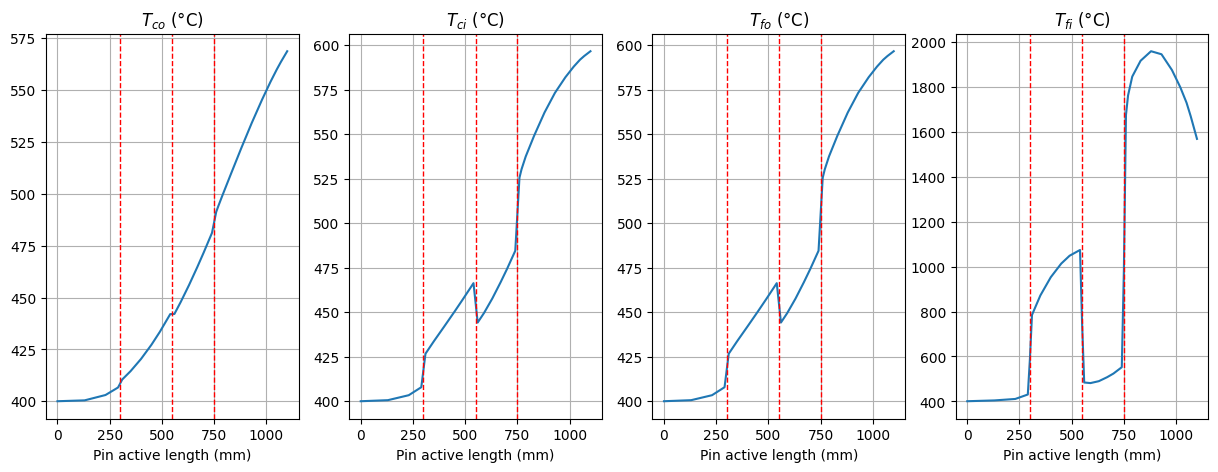

In [81]:
# new temperature profile calculated for inner ad outer cladding, and inner and outer fuel
for i in range(len(H)):
    Rci_final[i]=Rci_new[i] #new cladding geometry
    Tco_final[i]=T_final[i]+(Ppeak*Pf[i]*0.9*1000/(h_v_final[i]*2*math.pi*(Rco_final[i]/1000)))#outer cladding temperature

        
    sol=fsolve(Tcisolver, 400, args=(Tco_final[i], q[i]*0.9, Rco_final[i]-Rci_final[i]))
    Tci_final[i]=sol[0] #inner cladding temperature

    if contact_time[i]>1440 and contact_time[i]<0:
        Rfo_final[i]=Rfo_new[i] #fuel geometry (including void swelling)
        sol=fsolve(Tfosolver,1000, args=(Tci_final[i], q[i]*0.9, Rci_final[i], Rfo_final[i]))
        Tfo_final[i]=sol[0]  #fuel outer temperature
    else:
        Rfo_final[i]=Rci_final[i] #due to contact, outer fuel temperature and radius coincide with inner cladding fuel and radius
        Tfo_final[i]=Tci_final[i] 

    Rfi_final[i]=Rfi_new[i] #final inner radius accounts for thermal expansion and restructuring

    if H[i]<=300 or (H[i]>=550 and H[i]<=750): #fertile nods
        sol=fsolve(Tfisolver_UO_2,1000, args=(Tfo_final[i], q[i]*0.9, 1-rhof))
        Tfi_final[i]=sol[0]
        if Rfi_final[i]!=0: #check for formation of inner hole in fertile pellets, eventually the code shoud be changed
            print("alarm")
    else:
        if R_columnar[i]!=0: #different calculation for nodes where restructuring have taken place or not
            
            sol=fsolve(Tfisolver_MOX,500, args=(Tfo_final[i], q[i]*0.9, Rfo_final[i], R_columnar[i], 1-rhof, x_fissile))
            sol2=fsolve(Tfisolver_MOX, 500, args=(sol[0], q[i]*0.9, R_columnar[i],Rfi_final[i], 0, x_fissile))
            Tfi_final[i]=sol2[0]
        else:
            sol=fsolve(Tfisolver_MOX,500, args=(Tfo_final[i], q[i]*0.9, Rfo_final[i], Rfi_final[i], 1-rhof, x_fissile))
            Tfi_final[i]=sol[0]


#plots
fig, axs = plt.subplots(1, 4, figsize=(15,5))

axs[0].plot(H, Tco_final)
axs[0].set_title('$T_{co}$ (°C)')
axs[0].set_xlabel("Pin active length (mm)")
axs[0].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[0].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[0].grid()
axs[1].plot(H, Tci_final)
axs[1].set_title('$T_{ci}$ (°C)')
axs[1].set_xlabel("Pin active length (mm)")
axs[1].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[1].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[1].grid()
axs[2].plot(H, Tfo_final)
axs[2].set_title('$T_{fo}$ (°C)')
axs[2].set_xlabel("Pin active length (mm)")
axs[2].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[2].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[2].grid()
axs[3].plot(H, Tfi_final)
axs[3].set_title('$T_{fi}$ (°C)')
axs[3].set_xlabel("Pin active length (mm)")
axs[3].axvline(x=300, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=550, color="r", linestyle="--", linewidth=1)
axs[3].axvline(x=750, color="r", linestyle="--", linewidth=1)
axs[3].grid()

Due to the fuel-cladding contact, the maximum inner fuel temperature has further lowered.

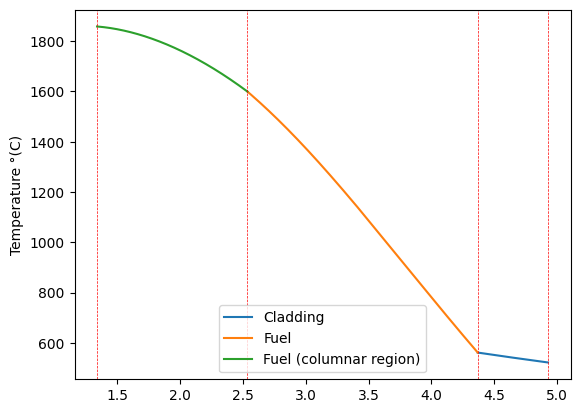

In [82]:
#Here, radial temperature profile in case of fuel-cladding contact is calculated

node=np.where(Tfi_final==max(Tfi_final))[0][0] #the node of interest has higher inner T.

#arrays for cladding and fuel
r_cladding_PCI=np.linspace(Rco_new[node], Rci_new[node], int((Rco_new[node]-Rci_new[node])*1000))
r_fuel_PCI=np.linspace(Rfo_final[node], R_columnar[node], int((Rfo_final[node]-R_columnar[node])*1000))

#cladding ODE integration
cladding_PCI_profile=integrate.solve_ivp(dTdr_cladding, t_span=(r_cladding_PCI[0], r_cladding_PCI[-1]), t_eval=r_cladding_PCI, y0=[Tco_final[node]], args=(q[node]*0.9,))
#fuel ODE integration
fuel_PCI_profile_external=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_fuel_PCI[0], r_fuel_PCI[-1]), t_eval=r_fuel_PCI, y0=[cladding_PCI_profile.y[0][-1]], args=(q[node]*0.9,0, 1-rhof, x_fissile))

#new columnar radius is found
r_fuel_PCI=np.delete(r_fuel_PCI, np.where(fuel_PCI_profile_external.y[0]>=1600))
Rfi_PCI=math.sqrt((r_fuel_PCI[-1]**2)-rhof*(r_fuel_PCI[-1]**2-Rfi_hot[node]**2))

#ODE for non-columnar region of the fuel is integrated again
fuel_PCI_profile_external=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_fuel_PCI[0], r_fuel_PCI[-1]), t_eval=r_fuel_PCI, y0=[cladding_PCI_profile.y[0][-1]], args=(q[node]*0.9,0, 1-rhof, x_fissile))

#array for columnar region
r_columnar_PCI=np.linspace(r_fuel_PCI[-1],  Rfi_PCI, int((R_columnar[node]-Rfi_final[node])*1000))

#ODE for columnar region of the fuel is integrated
fuel_PCI_profile_columnar=integrate.solve_ivp(dTdr_fuelMOX, t_span=(r_columnar_PCI[0], r_columnar_PCI[-1]), t_eval=r_columnar_PCI, y0=[fuel_PCI_profile_external.y[0][-1]],args=(q[node]*0.9,0, 0, x_fissile))

plt.plot(cladding_PCI_profile.t, cladding_PCI_profile.y[0], label="Cladding")
plt.plot(fuel_PCI_profile_external.t, fuel_PCI_profile_external.y[0], label="Fuel")
plt.plot(fuel_PCI_profile_columnar.t, fuel_PCI_profile_columnar.y[0], label="Fuel (columnar region)")
plt.axvline(x=r_cladding_PCI[0], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_cladding_PCI[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_fuel_PCI[-1], color="r", ls="--", linewidth=0.5)
plt.axvline(x=r_columnar_PCI[-1], color="r", ls="--", linewidth=0.5)
plt.ylabel("Temperature °(C)")
plt.legend()

As shown, once again there is some difference between the result of the axial and radial approach for maximum fuel temperature. Yet, for reasons already stated before, the latter is deemed more trustworthy.

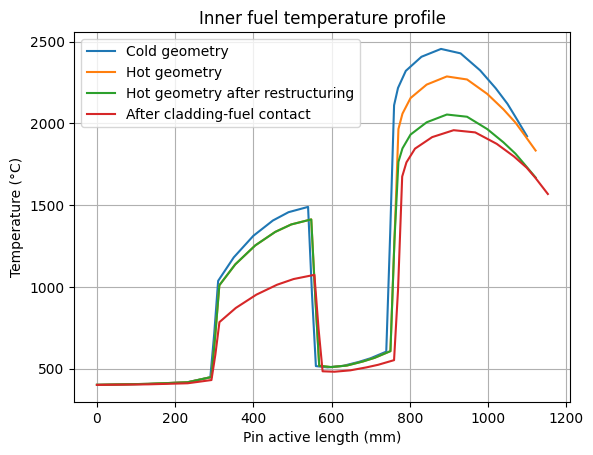

In [83]:
#Graphical comparison of the different analysis approaches for the inner fuel temperature, progressively taking into account more and more phenomena
plt.plot(H, Tfi, label="Cold geometry")
plt.plot(H_expanded, Tfi_hot, label="Hot geometry")
plt.plot(H_expanded, Tfi_res, label="Hot geometry after restructuring")
plt.plot(H_swelled, Tfi_final, label="After cladding-fuel contact")
plt.title("Inner fuel temperature profile")
plt.xlabel("Pin active length (mm)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()

The grapgh above displays how taking into account thermal expansion, restructiring and fuel cladding-fuel interaction changes the result of the analysis.

# Cladding mechanical verification

The aim of this section is to verify that the stress due to the maximum inner pressure and to the temperature gradient along the cladding radius do not result in a failure of the cladding. The thermal and mechanical stresses are evaluated separatedly and then used to calculate the equivalent stress.

Some useful functions used to implement some correlations:

In [84]:
def v_cladding(T):                                          #Cladding Poisson coefficient (-, T in celsius)
    return 	0.277+6*10**-5*T

def Young_c(T):                                             #Cladding Young modulus (GPa, T in celsius)                
    return 202.7-81.67*10**-3*T

def Young_f(T,Por):                                         #Fuel Young modulus (#MPa, T in celsius)
    return (22.43*10**4-31.19*T)*(1-2.6*Por)

def Rupture_strain_c(T):                                    #Cladding rupture strain (%, T in celsius)
    return 8+4.74*10**-3*(T-500)+6.2*10**-5*(T-500)*2

def Yield_stress_c(T):                                      #Cladding yield stress (MPa, T in °C)                  
    if T<600:
        return 555.5-0.25*T
    elif T<1000:
        return 405.5-0.775*(T-600)
    else:
        return 345.5-0.25*T

def UTS_c(T):                                               #Ultimate tensile cladding stress (MPa, T in °C)
    if T<600:
        return 700-0.3125*T
    elif T<1000:
        return 512.5-0.969*(T-600)
    else:
        return 437.5-0.3125*T

def Irr_creep_strain_rate_c(sigma_eq, neutron_flux):        #Cladding irradiation creep strain rate (%/h, stress in MPa)
        return 3.2*10**-24*E_av*neutron_flux*sigma_eq

def Tcreep_strain_rate_c(T,sigma_eq):                       #Thermal creep strain rate (T in °C, stress in MPa)
    return 2.3*10**14*math.e**(-84600/(R*(T+273.15)))*math.sinh(34.54*sigma_eq/(0.8075*R*(T+273.15)))


**Thermal stress**

Here the stress components due to thermal gradient along the radius of the cladding are calculated as:
\begin{equation}
    \sigma_r = M (\frac{r^2-r_i^2}{r_o^2-r_i^2}\int^{r_i}_{r_o}T(r) r dr -\int^r_{r_o}T(r)r dr)
\end{equation}

\begin{equation}
    \sigma_{\theta} = M (\frac{r^2+r_i^2}{r_o^2-r_i^2}\int^{r_i}_{r_o}T(r) r dr +\int^r_{r_o}T(r)r dr- T(r)r^2)
\end{equation}

\begin{equation}
    \sigma_{z} = \sigma_r + \sigma_{\theta}
\end{equation}
where 
\begin{equation}
    M = \frac{\alpha (T(r)) E(T(r))}{r(1-\nu)}
\end{equation}

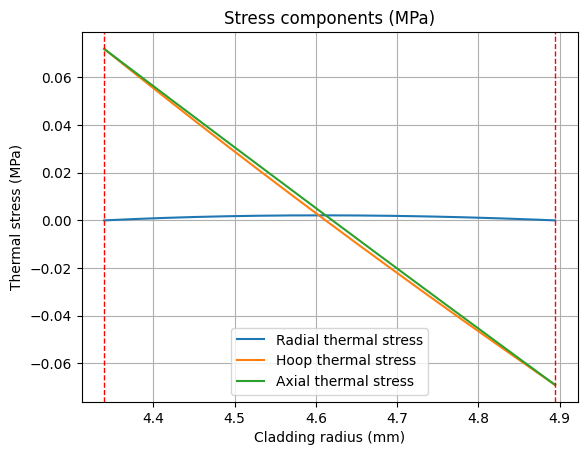

In [85]:
#Thermal

#the analysis focuses on the most critical node: the one with higher heat flux and hence higher inner T
node=np.where(Tfi_final==max(Tfi_final))[0][0] 

#array representing the cladding 
r_cladding=np.linspace(Rco_hot[node], Rci_hot[node], int((Rco_hot[node]-Rci_hot[node])*1000))

#cladding temperature profile calculated by integrating ODE
cladding_profile=integrate.solve_ivp(dTdr_cladding, t_span=(r_cladding[0], r_cladding[-1]), t_eval=r_cladding, y0=[Tco[node]], args=(q[node],))

#the profile is flipped to be later concatenated with 
rvals=np.flip(np.copy(cladding_profile.t))
Tvals=np.flip(np.copy(cladding_profile.y[0]))

#linear thermal expansion coefficient calculated along the radius of the cladding
alpha_c=epsilon(Tvals)/(Tvals-25)/100

#arrays containing the value of the stresses along the cladding
sigma_cladding_rt=np.zeros(len(rvals))
sigma_cladding_thetat=np.zeros(len(rvals))
sigma_cladding_zt=np.zeros(len(rvals))

#Temperature- radius product to be integrated
T_x_r=np.multiply(np.copy(Tvals),np.copy(rvals))
T_x_r2=np.multiply(np.copy(T_x_r),np.copy(rvals))

for i in range(len(rvals)):
    M=alpha_c[i]*Young_c(Tvals[i])*10**3/(1-v_c(Tvals[i]))/rvals[i]**2

    sigma_cladding_rt[i]=M*(((rvals[i]**2-rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)-np.trapz(T_x_r[0:i+1], rvals[0:i+1]))
    sigma_cladding_thetat[i]=M*(((rvals[i]**2+rvals[0]**2)/(rvals[-1]**2-rvals[0]**2))*np.trapz(T_x_r,rvals)+np.trapz(T_x_r[0:i+1], rvals[0:i+1])-T_x_r2[i])
    sigma_cladding_zt[i]=sigma_cladding_rt[i]+sigma_cladding_thetat[i]

plt.figure()
plt.plot(rvals, sigma_cladding_rt, label="Radial thermal stress")
plt.plot(rvals, sigma_cladding_thetat, label="Hoop thermal stress")
plt.plot(rvals, sigma_cladding_zt, label="Axial thermal stress")
plt.xlabel("Cladding radius (mm)")
plt.ylabel("Thermal stress (MPa)")
plt.title('Stress components (MPa)')
plt.axvline(x=rvals[0], color="r", ls="--", linewidth=1)
plt.axvline(x=rvals[-1], color="r", ls="--", linewidth=1)
plt.legend()
plt.grid()


**Mechanical stress**

Here the mechanical stress components along the radius of the cladding are calculated accounting for inner and outer pressure.

The radial mechanical stress will be:
\begin{equation}
    \sigma_r = \frac{a}{r^2}+b
\end{equation}
where a and b are parameters to estimated through two boundary conditions:
* the radial mechanical stress at the inner radius of the cladding must coincide with the inner pressure;
* the radial mechanical stress at the outer radius of the cladding must coincide with the outer pressure.
Here, assuming a worst case scenario (wider possible pressure difference between outer and inner p.), the inner pressure is 5 MPa and the outer pressure is 0 MPa.

Then, the hoop stress is calculated as:
\begin{equation}
    \sigma_\theta = \sigma_r + r\frac{d\sigma_r}{dr}
\end{equation}



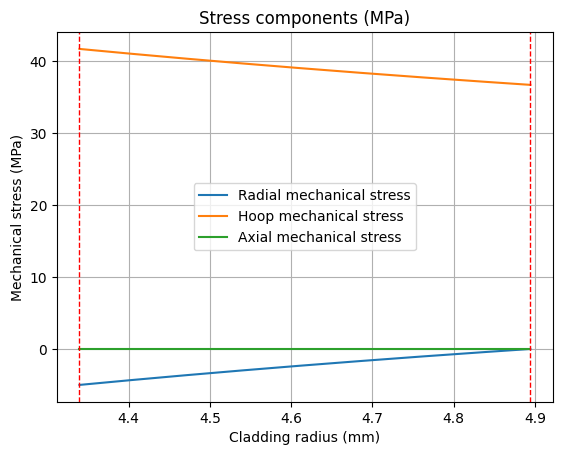

In [86]:
#Mechanical
a,b,r=sp.symbols("a b r") #parameters

sigma_r=a/r**2+b          #radial stress function

#arrays containing the value of the stresses along the cladding
sigma_cladding_rm=np.zeros(len(rvals))
sigma_cladding_thetam=np.zeros(len(rvals))
sigma_cladding_zm=np.zeros(len(rvals))

#boundary condition implementation
C1=sp.Eq(sigma_r.subs(r,rvals[0]),-5) #MPa
C2=sp.Eq(sigma_r.subs(r,rvals[-1]),0) #MPa

#substitution of the parameters found with the b.c.
parameters=sp.solve((C1,C2), [a,b])
sigma_r=sigma_r.subs(parameters)

#hoop stress
sigma_theta=sigma_r+r*sigma_r.diff(r,1)

for i in range(len(rvals)):
    sigma_cladding_rm[i]=sigma_r.subs(r, rvals[i])
    sigma_cladding_thetam[i]=sigma_theta.subs(r, rvals[i])

plt.figure()
plt.plot(rvals, sigma_cladding_rm, label="Radial mechanical stress")
plt.plot(rvals, sigma_cladding_thetam, label="Hoop mechanical stress")
plt.plot(rvals, sigma_cladding_zm, label="Axial mechanical stress")
plt.xlabel("Cladding radius (mm)")
plt.ylabel("Mechanical stress (MPa)")
plt.title('Stress components (MPa)')
plt.axvline(x=rvals[0], color="r", ls="--", linewidth=1)
plt.axvline(x=rvals[-1], color="r", ls="--", linewidth=1)
plt.legend()
plt.grid()

**Equivalent stress**

The components of the equivalent stress are found by summing mechanical and thermal stresses component-wise. Then, the equivalent stress is found by using the Von Mises criterion:
\begin{equation}
    \sigma_{eq}= \sqrt{(\sigma_r-\sigma_\theta)^2 + (\sigma_r-\sigma_z)^2 + (\sigma_z-\sigma_\theta)^2}
\end{equation}

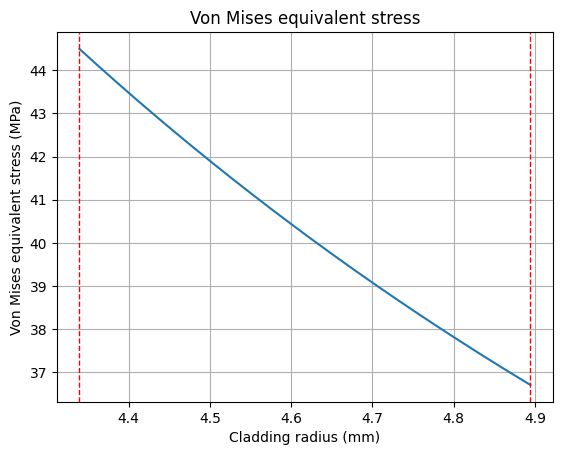

In [87]:
#equivalent stress
equivalent_stress=np.zeros(len(rvals))

sigma_cladding_r=sigma_cladding_rm+sigma_cladding_rt
sigma_cladding_theta=sigma_cladding_thetam+sigma_cladding_thetat
sigma_cladding_z=sigma_cladding_zm+sigma_cladding_zt
for i in range(len(rvals)):
    equivalent_stress[i]=math.sqrt(((sigma_cladding_r[i]-sigma_cladding_theta[i])**2+(sigma_cladding_r[i]-sigma_cladding_z[i])**2+(sigma_cladding_theta[i]-sigma_cladding_z[i])**2)/2)
plt.figure()
plt.plot(rvals, equivalent_stress)
plt.xlabel("Cladding radius (mm)")
plt.ylabel("Von Mises equivalent stress (MPa)")
plt.title("Von Mises equivalent stress")
plt.axvline(x=rvals[0], color="r", ls="--", linewidth=1)
plt.axvline(x=rvals[-1], color="r", ls="--", linewidth=1)
plt.grid()

The equivalent stress is way below the yield stress: the material is still behaving in an elastic way.

# PCI: pellet-cladding interaction

Due to the void swelling of the fuel, eventually some critical pellets will swell to the point of touching the cladding and applying further pressure as the fuel keeps swllelling. In order to find the Von Mises equivalent stress under these conditions, the mechanical stress is found just as before but instead of using the inner gas pressure as boundary condition, the pellet-cladding contact pressure will be used instead. 

The contact pressure was calculated as:
\begin{equation}
    P_{contact}=(\frac{i}{b})\frac{1}{\frac{1}{E_{cladding}}(\frac{b^2+c^2}{c^2-b^2}+\frac{1}{\nu_{cladding}})+\frac{1}{E_{fuel}}(\frac{a^2+b^2}{b^2-a^2}-\frac{1}{\nu_{fuel}})}
\end{equation}
where
\begin{equation}
    i\simeq \frac{1}{3}(\frac{\Delta V}{V})_{fuel}Rfuel
\end{equation}
and  a, b and c are the inner fuel radius, outer fuel radius (that since contact is equal to the inner cladding radius) and outer cladding radius at the end of the pin operation (when we expect the maximum swelling, hence the maximum stress).

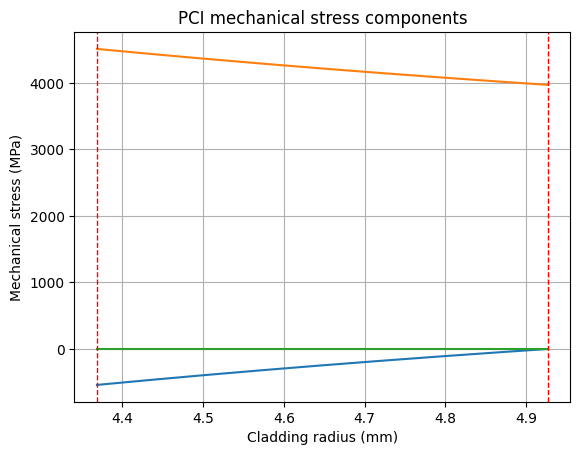

In [88]:
#radii
a=Rfi_new[node]
b=Rfo_new[node]
c=Rco_final[node]

#contact pressure
i=(1/3)*Rfo_hot[node]*(0.07*(burnup_final[node]*(1440-contact_time[node])/1440)/100)
p_contact=(i/b)/(((1000*Young_c(cladding_PCI_profile.y[0][-1]))**-1*((b**2+c**2)/(c**2-b**2)+1/v_cladding(cladding_PCI_profile.y[0][-1])))+(Young_f(cladding_PCI_profile.y[0][-1], Por=0.05)**-1*((a**2+b**2)/(b**2-a**2)-1/v_f)))

#stress calculation
rvals=np.flip(cladding_PCI_profile.t)
a,b,r=sp.symbols("a b r")
sigma_r=a/r**2+b

sigma_cladding_rm=np.zeros(len(rvals))
sigma_cladding_thetam=np.zeros(len(rvals))
sigma_cladding_zm=np.zeros(len(rvals))
C1=sp.Eq(sigma_r.subs(r,rvals[0]),-p_contact) #MPa
C2=sp.Eq(sigma_r.subs(r,rvals[-1]),0) #MPa

parameters=sp.solve((C1,C2), [a,b])
sigma_r=sigma_r.subs(parameters)
sigma_theta=sigma_r+r*sigma_r.diff(r,1)

for i in range(len(rvals)):
    sigma_cladding_rm[i]=sigma_r.subs(r, rvals[i])
    sigma_cladding_thetam[i]=sigma_theta.subs(r, rvals[i])


plt.figure()
plt.plot(rvals, sigma_cladding_rm, label="Radial component")
plt.plot(rvals, sigma_cladding_thetam, label="Hoop component")
plt.plot(rvals, sigma_cladding_zm, label="Axial component")
plt.xlabel("Cladding radius (mm)")
plt.ylabel("Mechanical stress (MPa)")
plt.title("PCI mechanical stress components")
plt.axvline(x=rvals[0], color="r", ls="--", linewidth=1)
plt.axvline(x=rvals[-1], color="r", ls="--", linewidth=1)
plt.grid()




The mechanical stress in this case is orders of magnitude higher than the thermal stress. The Von Mises equivalent stress is calculated accounting only for mechanical stresses.

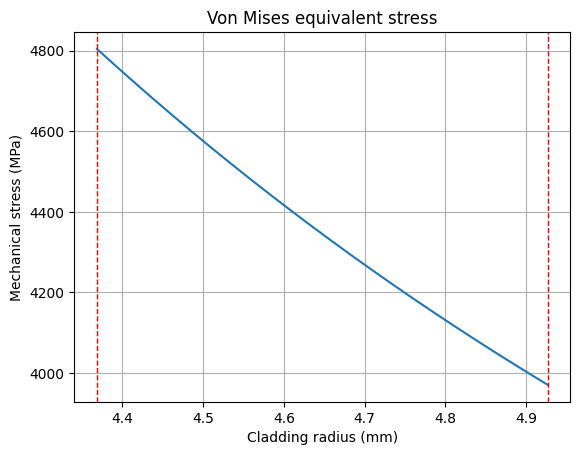

In [89]:
#equivalent stress
equivalent_stress=np.zeros(len(rvals))

sigma_cladding_r=sigma_cladding_rm
sigma_cladding_theta=sigma_cladding_thetam
sigma_cladding_z=sigma_cladding_zm
for i in range(len(rvals)):
    equivalent_stress[i]=math.sqrt(((sigma_cladding_r[i]-sigma_cladding_theta[i])**2+(sigma_cladding_r[i]-sigma_cladding_z[i])**2+(sigma_cladding_theta[i]-sigma_cladding_z[i])**2)/2)
plt.figure()
plt.plot(rvals, equivalent_stress)
plt.title("Von Mises equivalent stress")
plt.xlabel("Cladding radius (mm)")
plt.ylabel("Mechanical stress (MPa)")
plt.axvline(x=rvals[0], color="r", ls="--", linewidth=1)
plt.axvline(x=rvals[-1], color="r", ls="--", linewidth=1)
plt.grid()


This value is way above both the yield tensile stress and the ultimate tensile strength. Clearly, at some point during the swelling the cladding will be strained and the deformation will accomodate the swelling. To verify the compliance of the pin with the design limits, we must ensure that the conditions of temperature, mechanical stress and operative life of the pin are compatible among themselves.

**Given $T_{des}$ and $\sigma_{des}$ verify $t_r$**

To verify that, given the temperature and stress that by design the cladding undergoes, the rupture strain limit is not reached, the strain rate is calculated on the basis of T. ad $\sigma$ taking into account the mechanical strain rate, the thermal creep strain rate and the irradiation creep strain rate.

In [90]:
#the strain day will happen somewhere between contact day and end of operations
days=np.linspace(contact_time[node],1440, int(1440-contact_time[node])+1) #possible days

#finding the strain day
for t in range(len(days)):
    
    Rci_strain=Rci_hot[node]*(1+(0.01*clad_void_swelling(cladding_PCI_profile.y[0][-1], tot_neutron_flux_local[3][node], days[t]*24*3600)/3))
    if Rci_strain/Rci_hot[node]>=(1+0.002):
        T_strain=days[t]
        break

#the stress during the strain phase is supposed to be the yielding stress 
SigmaEq=Yield_stress_c(cladding_PCI_profile.y[0][-1])

#at the beginning of the strain the deformation is 0.2%
strain=0.2

#the limit is the rupture strain
limit=Rupture_strain_c(np.average(cladding_PCI_profile.y[0]))

#the root of this function is the rupture day
def final_strain(t):
    
    return float(strain+(Irr_creep_strain_rate_c(SigmaEq, tot_neutron_flux_local[3, node])+Tcreep_strain_rate_c(np.average(cladding_PCI_profile.y[0]),SigmaEq)+clad_void_swelling(np.average(cladding_PCI_profile.y[0]), tot_neutron_flux_local[3][node], T_strain*24*3600)/((1440-T_strain)*24))*(t-T_strain)*24)-limit

t_r=fsolve(final_strain, 1440)

print("The ratio between the time to rupture starting from the strain day and the remaining opreation days is "+ str(t_r[0]/(1440-T_strain))[0:4])


The ratio between the time to rupture starting from the strain day and the remaining opreation days is 4.95


As shown, the time to rupture is almost five times more than the remaining operative life, ensuring safe operation.

**Given $t_{des}$ and $\sigma_{des}$ verify $T_r$**

To verify that, given the operative life of the pin and stress that by design the cladding undergoes, the temperature of the cladding ensures the right thermo-mechanical behavior, the time under strain and equivalent stress are used to find the limit temperature by means of the Larson-Miller parameter.

In [91]:
#this function takes in input a stress and a time under strain, and returns the limit temperature
def LMP_T(sigma, t):
    T=sp.symbols("T")
    LMP=(2060-sigma)/0.095 #calculation of the LMP through a linear regression
    T_rupture=sp.solve(sp.Eq(LMP, (T+273.15)*(17.125+math.log(t*24,10)))) #T that leads to rupture on the last day of operation
    return T_rupture

print("The ratio between the limit temperature and the average cladding temperature is "+ str(LMP_T(SigmaEq, 1440-T_strain)[0]/np.average(cladding_PCI_profile.y[0]))[0:5])

The ratio between the limit temperature and the average cladding temperature is 1.008


As shown, the temperature is low enough to ensure safe operation.

**Given $T_{des}$ and $t_{des}$ verify $\sigma_r$**

The same procedure used to verify the compliance with the temperature limits is employed for the stress.

In [92]:
#this function takes in input a temperature and a time under strain, and returns the limit temperature
def LMP_sigma(T, t):
    sigma=sp.symbols("sigma")
    LMP=(T+273.15)*(17.125+math.log(t*24,10))
    sigma_rupture=sp.solve(sp.Eq(LMP, (2060-sigma)/0.095 ))
    return sigma_rupture

print("The ratio between the limit stress and the equivalent stress is "+ str(LMP_sigma(np.average(cladding_PCI_profile.y[0]), 1440-T_strain)[0]/SigmaEq)[0:5])


The ratio between the limit stress and the equivalent stress is 1.022


With this last step the compliance of the pin with the design limits is verified.